# Homework 2
# Parsa Daghigh

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Imports

In [ ]:
! pip install tensorpac
import scipy.io as sio
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt, find_peaks
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from scipy.stats import mode
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mutual_info_score
from itertools import combinations
from scipy.spatial.distance import squareform, pdist
from scipy.stats import kendalltau
import statsmodels.api as sm
from tensorpac import Pac
from scipy.signal import welch
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.6/423.6 kB 9.6 MB/s eta 0:00:00


## Spike sorting from scratch

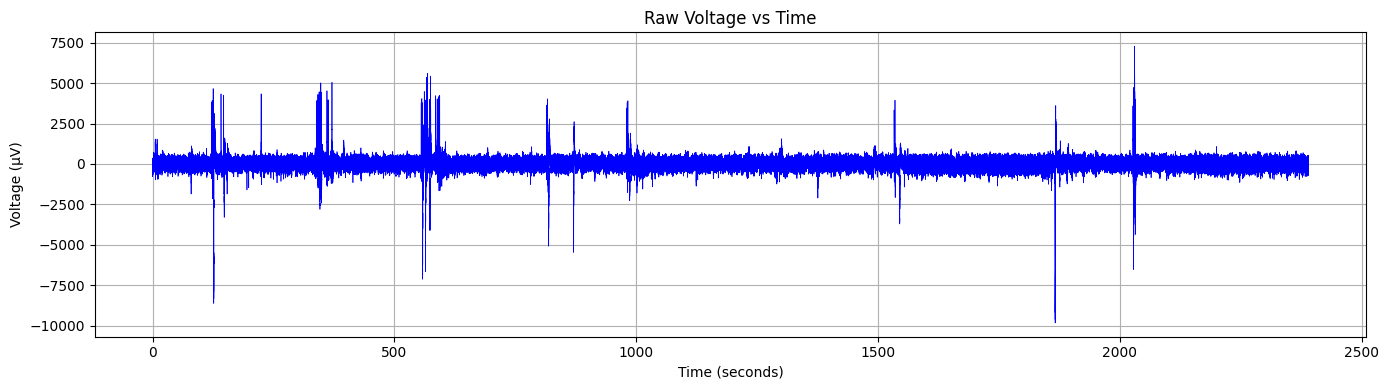

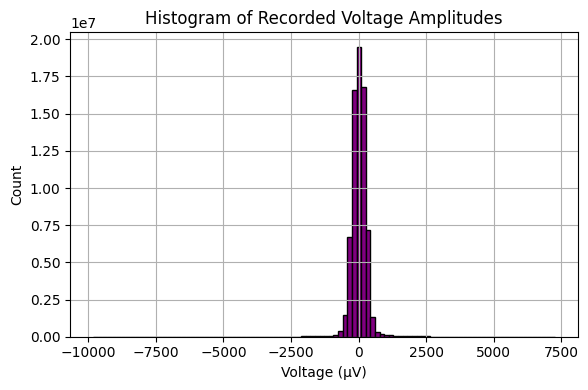

In [ ]:
file_path = '/content/drive/MyDrive/Cognitive_HW2/singleIT.mat'
with h5py.File(file_path, 'r') as f:

    signal = f['data_IT'][:]

signal = signal.flatten()

Fs = 30000
time = np.arange(signal.size) / Fs

# Plot 1: Voltage vs Time
plt.figure(figsize=(14, 4))
plt.plot(time, signal, color='blue', linewidth=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (µV)')
plt.title('Raw Voltage vs Time')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Histogram of Amplitudes
plt.figure(figsize=(6, 4))
plt.hist(signal, bins=100, color='purple', edgecolor='black')
plt.xlabel('Voltage (µV)')
plt.ylabel('Count')
plt.title('Histogram of Recorded Voltage Amplitudes')
plt.grid(True)
plt.tight_layout()
plt.show()

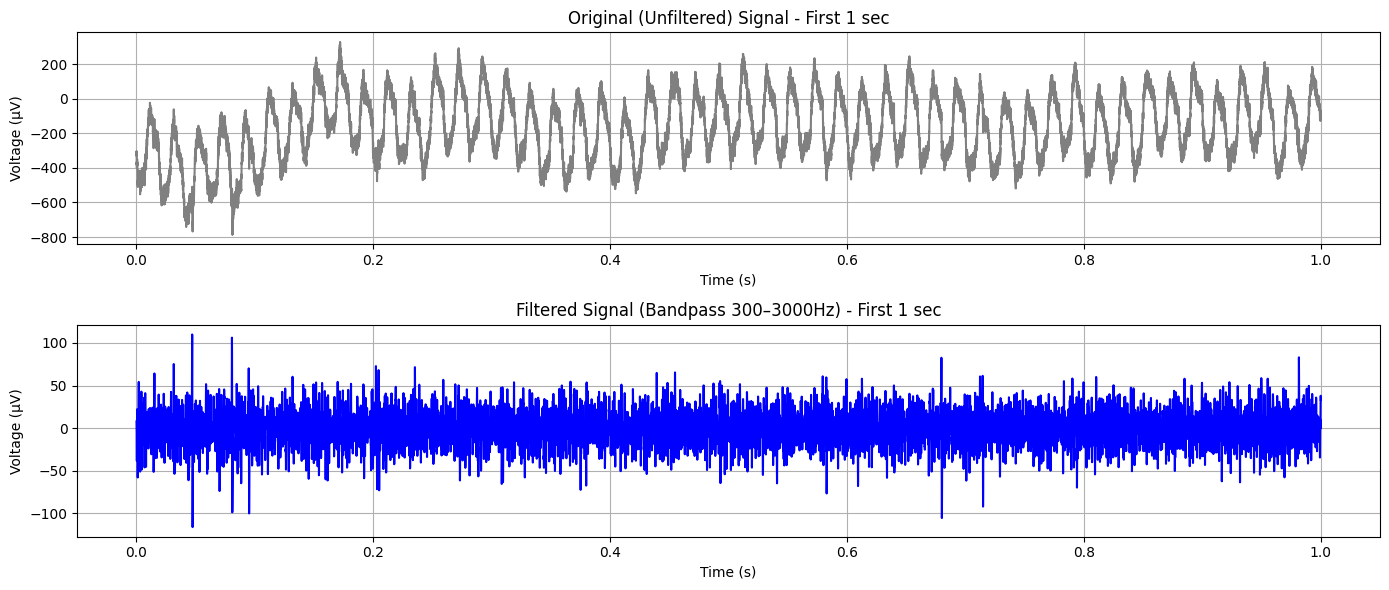

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

lowcut = 300
highcut = 3000
b, a = butter_bandpass(lowcut, highcut, Fs, order=3)
signal_filtered = filtfilt(b, a, signal)

# Plot original vs filtered
plt.figure(figsize=(14, 6))

plt.subplot(2,1,1)
plt.plot(time[:30000], signal[:30000], color='gray')
plt.title('Original (Unfiltered) Signal - First 1 sec')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (µV)')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(time[:30000], signal_filtered[:30000], color='blue')
plt.title('Filtered Signal (Bandpass 300–3000Hz) - First 1 sec')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (µV)')
plt.grid(True)

plt.tight_layout()
plt.show()


Calculated threshold θ = 104.11 μV
Detected 29031 negative and 16405 positive peaks.
Total detected spikes: 45436
Extracted 45436 waveforms, each with 121 samples.


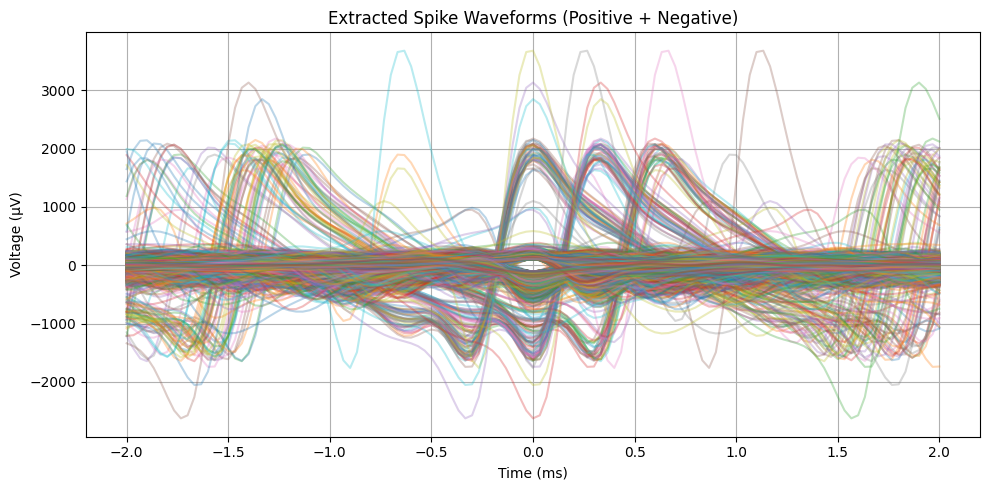

In [ ]:

# Calculate noise level (σ_n) and threshold θ
sigma_n = np.median(np.abs(signal_filtered)) / 0.6745
theta = 5 * sigma_n
print(f"Calculated threshold θ = {theta:.2f} μV")

# negative and positive spikes using threshold
neg_peaks, _ = find_peaks(-signal_filtered, height=theta)
pos_peaks, _ = find_peaks(signal_filtered, height=theta)

all_peaks = np.sort(np.concatenate((neg_peaks, pos_peaks)))
print(f"Detected {len(neg_peaks)} negative and {len(pos_peaks)} positive peaks.")
print(f"Total detected spikes: {len(all_peaks)}")

pre_samples = int(0.002 * Fs)
post_samples = int(0.002 * Fs)

valid_peaks = all_peaks[(all_peaks > pre_samples) & (all_peaks < len(signal_filtered) - post_samples)]

# spike waveforms
waveforms = []
for p in valid_peaks:
    wf = signal_filtered[p - pre_samples : p + post_samples + 1]
    waveforms.append(wf)
waveforms = np.array(waveforms)
print(f"Extracted {waveforms.shape[0]} waveforms, each with {waveforms.shape[1]} samples.")

plt.figure(figsize=(10, 5))
for wf in waveforms:
    plt.plot(np.linspace(-2, 2, waveforms.shape[1]), wf, alpha=0.3)
plt.title("Extracted Spike Waveforms (Positive + Negative)")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (μV)")
plt.grid(True)
plt.tight_layout()
plt.show()

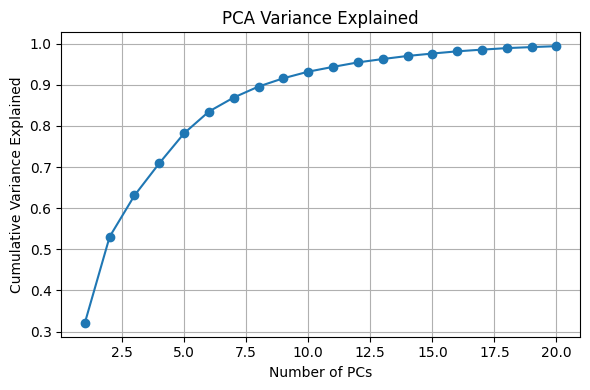

In [ ]:
pca = PCA()
pca.fit(waveforms)

scores = pca.transform(waveforms)

# Variance explained
explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, 21), cum_explained[:20], marker='o')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Variance Explained')
plt.title('PCA Variance Explained')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
PC1 = scores[:, 0]
PC2 = scores[:, 1]
PC3 = scores[:, 2]

print(f"Variance explained by PC1–PC3: {cum_explained[2]*100:.1f}%")

Variance explained by PC1–PC3: 63.1%


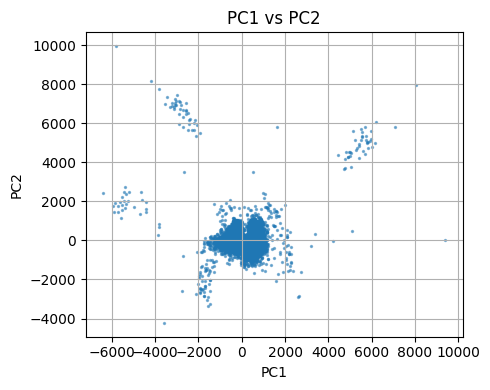

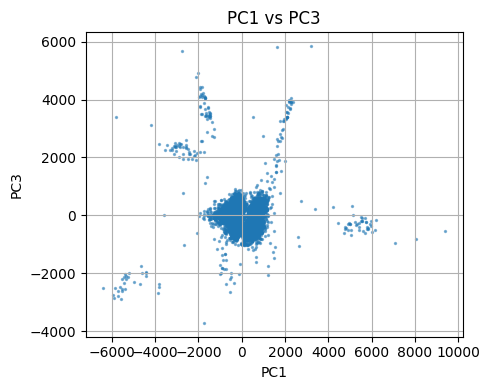

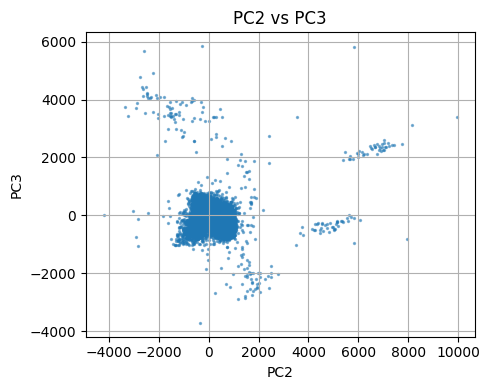

In [ ]:
# PC1 vs PC2
plt.figure(figsize=(5,4))
plt.scatter(PC1, PC2, s=2, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC1 vs PC2')
plt.grid(True)
plt.tight_layout()
plt.show()

# PC1 vs PC3
plt.figure(figsize=(5,4))
plt.scatter(PC1, PC3, s=2, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title('PC1 vs PC3')
plt.grid(True)
plt.tight_layout()
plt.show()

# PC2 vs PC3
plt.figure(figsize=(5,4))
plt.scatter(PC2, PC3, s=2, alpha=0.5)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('PC2 vs PC3')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
n_pcs = 3
features = scores[:, :n_pcs]

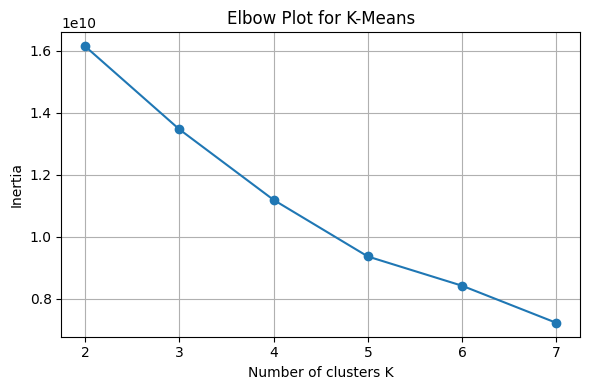

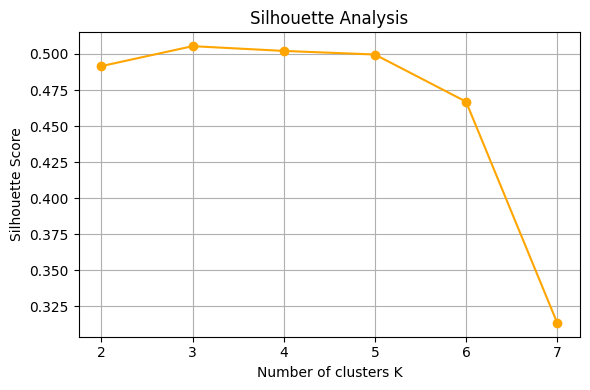

In [ ]:
inertias = []
silhouettes = []
K_range = range(2, 8)  # K = 2…7

for K in K_range:
    km = KMeans(n_clusters=K, random_state=0).fit(features)
    inertias.append(km.inertia_)
    sil = silhouette_score(features, km.labels_)
    silhouettes.append(sil)

# Elbow curve
plt.figure(figsize=(6,4))
plt.plot(list(K_range), inertias, marker='o')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Plot for K-Means')
plt.grid(True)
plt.tight_layout()
plt.show()

# Silhouette scores
plt.figure(figsize=(6,4))
plt.plot(list(K_range), silhouettes, marker='o', color='orange')
plt.xlabel('Number of clusters K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
best_K = 3
km = KMeans(n_clusters=best_K, random_state=0).fit(features)
labels = km.labels_

print(f"Clustering done with K = {best_K}.")

Clustering done with K = 3.


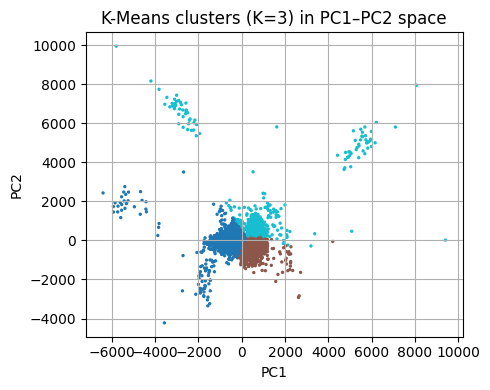

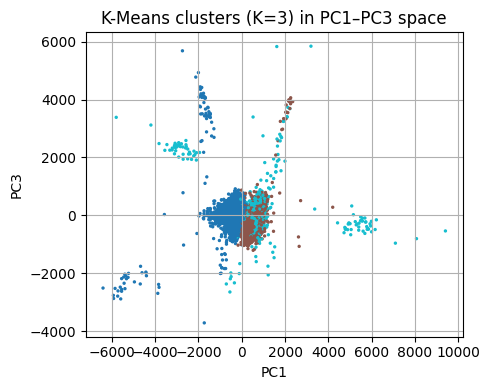

In [ ]:
# PC1 vs PC2
plt.figure(figsize=(5,4))
plt.scatter(features[:,0], features[:,1], c=labels, s=2, cmap='tab10')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'K-Means clusters (K={best_K}) in PC1–PC2 space')
plt.grid(True)
plt.tight_layout()
plt.show()

# PC1 vs PC3
plt.figure(figsize=(5,4))
plt.scatter(features[:,0], features[:,2], c=labels, s=2, cmap='tab10')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title(f'K-Means clusters (K={best_K}) in PC1–PC3 space')
plt.grid(True)
plt.tight_layout()
plt.show()

#### First threshold

In [ ]:
max_gt_sample = 120000
with h5py.File('/content/drive/MyDrive/Cognitive_HW2/Spikes.mat', 'r') as f:
    true_times = np.array(f['ind_spikes_it']).flatten().astype(int)

true_times_trimmed = true_times[true_times <= max_gt_sample]

valid_peaks_trimmed = valid_peaks[valid_peaks <= max_gt_sample]

window = int(0.001 * Fs)

matched = set()
tp = 0
for d in valid_peaks_trimmed:
    close = np.where(np.abs(true_times_trimmed - d) <= window)[0]
    if close.size > 0:
        tp += 1
        matched.add(true_times_trimmed[close[0]])

fp = len(valid_peaks_trimmed) - tp
fn = len(true_times_trimmed) - len(matched)

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

print(f"Restricted to [0–{max_gt_sample}] samples:")
print(f"True positives:   {tp}")
print(f"False positives:  {fp}")
print(f"False negatives:  {fn}")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")


Restricted to [0–120000] samples:
True positives:   19
False positives:  0
False negatives:  77685
Precision: 1.000, Recall: 0.000, F1-score: 0.000


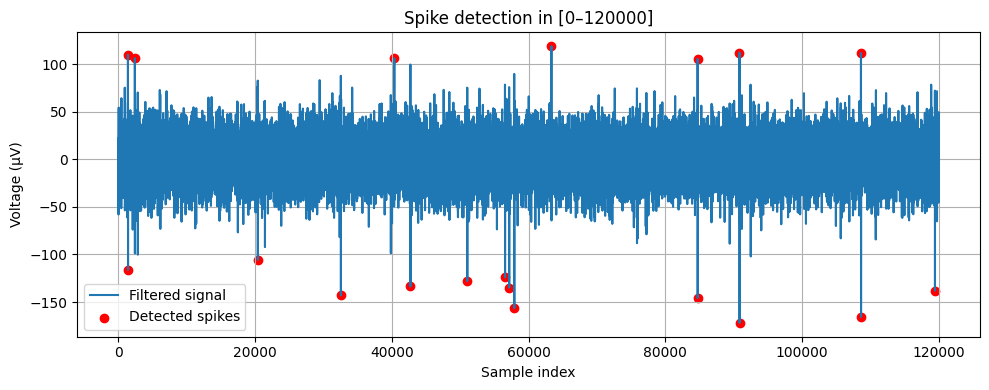

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(signal_filtered[:120000], label='Filtered signal')
plt.scatter(valid_peaks_trimmed, signal_filtered[valid_peaks_trimmed], color='red', label='Detected spikes')
plt.title("Spike detection in [0–120000]")
plt.xlabel("Sample index")
plt.ylabel("Voltage (µV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### New threshold

New threshold θ_new = 154.71 µV
Detected 3 negative and 0 positive peaks.
Total spikes in [0–12000]: 3


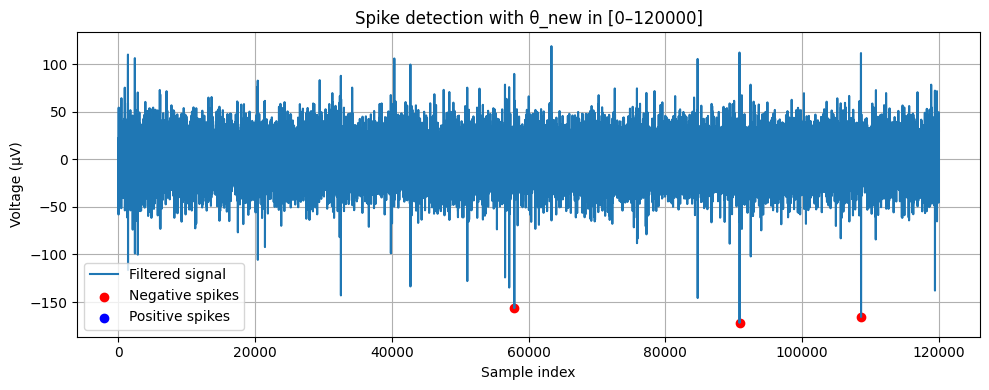

In [ ]:
eval_region = signal_filtered[:120000]

theta_new = 0.9 * np.max(np.abs(eval_region))
print(f"New threshold θ_new = {theta_new:.2f} µV")

neg_peaks, _ = find_peaks(-eval_region, height=theta_new)
pos_peaks, _ = find_peaks(eval_region, height=theta_new)

all_peaks = np.sort(np.concatenate([neg_peaks, pos_peaks]))
print(f"Detected {len(neg_peaks)} negative and {len(pos_peaks)} positive peaks.")
print(f"Total spikes in [0–12000]: {len(all_peaks)}")

plt.figure(figsize=(10, 4))
plt.plot(eval_region, label='Filtered signal')
plt.scatter(neg_peaks, eval_region[neg_peaks], color='red', label='Negative spikes')
plt.scatter(pos_peaks, eval_region[pos_peaks], color='blue', label='Positive spikes')
plt.title("Spike detection with θ_new in [0–120000]")
plt.xlabel("Sample index")
plt.ylabel("Voltage (µV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Calculated threshold θ = 58.05 µV (3 × σₙ)
Detected 119 negative and 89 positive peaks.
Total detected spikes: 208


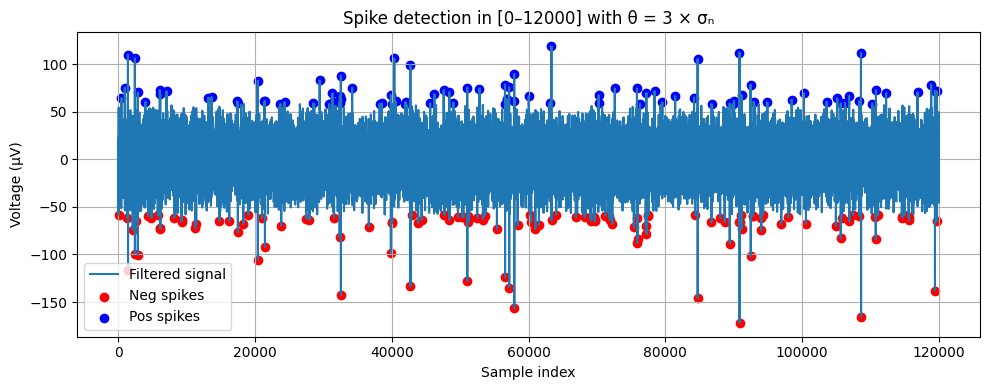

In [ ]:
eval_region = signal_filtered[:120000]

sigma_n = np.median(np.abs(eval_region)) / 0.6745
theta = 3 * sigma_n  # Use a lower multiplier than 5
print(f"Calculated threshold θ = {theta:.2f} µV (3 × σₙ)")

neg_peaks, _ = find_peaks(-eval_region, height=theta)
pos_peaks, _ = find_peaks(eval_region, height=theta)
all_peaks = np.sort(np.concatenate([neg_peaks, pos_peaks]))
print(f"Detected {len(neg_peaks)} negative and {len(pos_peaks)} positive peaks.")
print(f"Total detected spikes: {len(all_peaks)}")

plt.figure(figsize=(10, 4))
plt.plot(eval_region, label='Filtered signal')
plt.scatter(neg_peaks, eval_region[neg_peaks], color='red', label='Neg spikes')
plt.scatter(pos_peaks, eval_region[pos_peaks], color='blue', label='Pos spikes')
plt.title("Spike detection in [0–12000] with θ = 3 × σₙ")
plt.xlabel("Sample index")
plt.ylabel("Voltage (µV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Using tSNE instead of PCA

In [ ]:
max_spikes = 10000
idx = np.random.choice(len(waveforms), size=min(max_spikes, len(waveforms)), replace=False)
wave_sub = waveforms[idx]

tsne = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=0, verbose=1)
features_tsne = tsne.fit_transform(wave_sub)  # shape: (n_samples, 3)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...
[t-SNE] Computed neighbors for 10000 samples in 1.519s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 104.894438
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.139793
[t-SNE] KL divergence after 1000 iterations: 1.614681


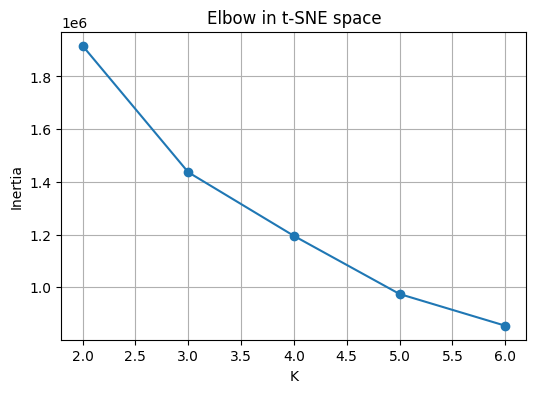

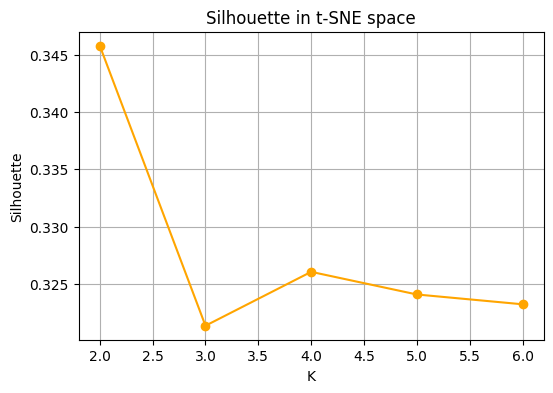

In [ ]:
Ks = range(2, 7)
inertias = []
sils = []

for K in Ks:
    km = KMeans(n_clusters=K, random_state=0).fit(features_tsne)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(features_tsne, km.labels_))

plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker='o')
plt.title('Elbow in t-SNE space'); plt.xlabel('K'); plt.ylabel('Inertia'); plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(Ks, sils, marker='o', color='orange')
plt.title('Silhouette in t-SNE space'); plt.xlabel('K'); plt.ylabel('Silhouette'); plt.grid(True)
plt.show()

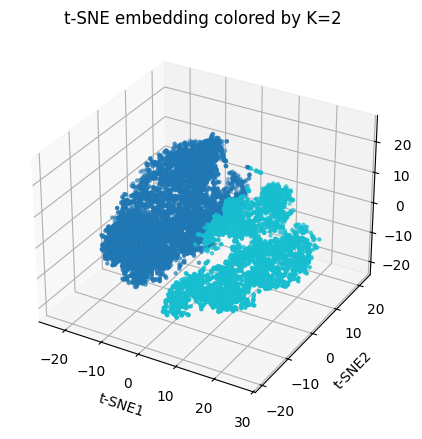

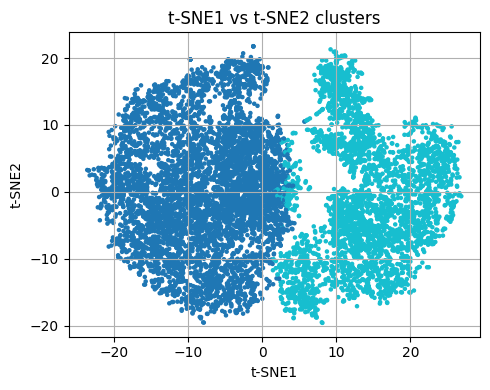

In [ ]:
best_K = 2
km = KMeans(n_clusters=best_K, random_state=0).fit(features_tsne)
labels_tsne = km.labels_

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(features_tsne[:,0], features_tsne[:,1], features_tsne[:,2],
                c=labels_tsne, s=5, cmap='tab10')
ax.set_xlabel('t-SNE1'); ax.set_ylabel('t-SNE2'); ax.set_zlabel('t-SNE3')
plt.title(f't-SNE embedding colored by K={best_K}')
plt.show()

# 2D pairwise
plt.figure(figsize=(5,4))
plt.scatter(features_tsne[:,0], features_tsne[:,1], c=labels_tsne, s=5, cmap='tab10')
plt.xlabel('t-SNE1'); plt.ylabel('t-SNE2')
plt.title('t-SNE1 vs t-SNE2 clusters')
plt.grid(True); plt.tight_layout(); plt.show()


## Analysis of Single Neuron Activity

### PSTH

Neuron 60 raster shape: (550, 5000)
Neuron 60 cm/index shape: (5000,)
First 10 picture indices: ['<HDF5 object reference>' '<HDF5 object reference>'
 '<HDF5 object reference>' '<HDF5 object reference>'
 '<HDF5 object reference>' '<HDF5 object reference>'
 '<HDF5 object reference>' '<HDF5 object reference>'
 '<HDF5 object reference>' '<HDF5 object reference>']


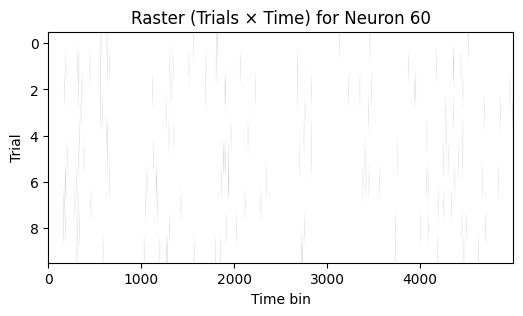

In [ ]:
file_path = '/content/drive/MyDrive/Cognitive_HW2/dataVasati.mat'
neuron_index = 60

with h5py.File(file_path, 'r') as f:
    st_all    = f['SpikeTrain_it_all']
    raster_ds = st_all['data']
    cm_ds     = st_all['cm']

    raster_ref = raster_ds[neuron_index, 0]
    raster0    = np.array(f[raster_ref])
    print(f"Neuron {neuron_index} raster shape:", raster0.shape)

    cm_ref    = cm_ds[neuron_index, 0]
    cm_group  = f[cm_ref]
    cm_index  = np.array(cm_group['index']).squeeze().astype(str)
    print(f"Neuron {neuron_index} cm/index shape:", cm_index.shape)
    print("First 10 picture indices:", cm_index[:10])

    # Raster plot
    plt.figure(figsize=(6,3))
    plt.imshow(raster0[:10, :], aspect='auto', cmap='gray_r')
    plt.title(f'Raster (Trials × Time) for Neuron {neuron_index}')
    plt.xlabel('Time bin')
    plt.ylabel('Trial')
    plt.show()


Raster shape (trials × time): (5000, 550)


<ipython-input-26-6efe185baab3>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pic_nums.append(int(value))


Picture indices shape: (5000,)
First 10 picture indices: [149  23 254 188 180 487 277 483 292 182]


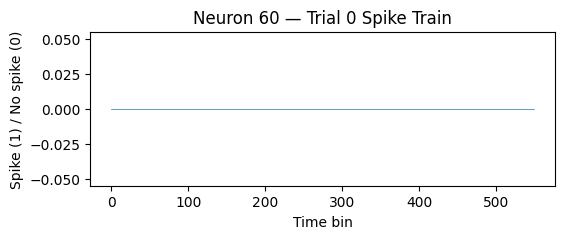

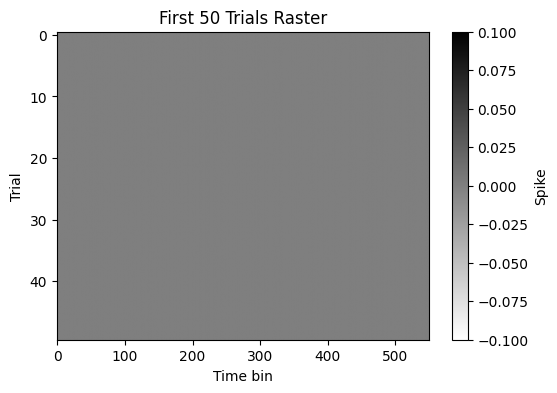

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


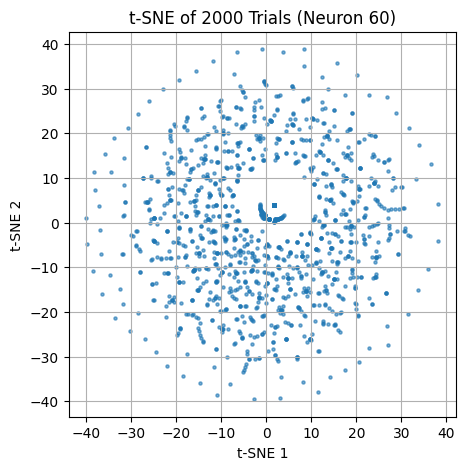

In [ ]:
neuron_index = 60
with h5py.File(file_path, 'r') as f:
    st_all     = f['SpikeTrain_it_all']
    raster_ref = st_all['data'][neuron_index, 0]
    cm_ref     = st_all['cm']  [neuron_index, 0]


    raw       = np.array(f[raster_ref])
    raster0   = raw.T
    print("Raster shape (trials × time):", raster0.shape)

    # Dereference cm/index properly
    idx_dataset = f[cm_ref]['index']
    idx_refs    = idx_dataset[()]
    idx_refs    = idx_refs.flatten()
    pic_nums = []
    for ref in idx_refs:
        value = f[ref][()]
        pic_nums.append(int(value))
    pic_nums = np.array(pic_nums)
    print("Picture indices shape:", pic_nums.shape)
    print("First 10 picture indices:", pic_nums[:10])


    plt.figure(figsize=(6,2))
    plt.plot(raster0[0], lw=0.5)
    plt.title(f"Neuron {neuron_index} — Trial 0 Spike Train")
    plt.xlabel("Time bin")
    plt.ylabel("Spike (1) / No spike (0)")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.imshow(raster0[:50], aspect='auto', cmap='gray_r')
    plt.title("First 50 Trials Raster")
    plt.xlabel("Time bin")
    plt.ylabel("Trial")
    plt.colorbar(label="Spike")
    plt.show()

    subsamp = min(2000, raster0.shape[0])
    sel     = np.random.choice(raster0.shape[0], subsamp, replace=False)
    X       = raster0[sel]  # shape (subsamp, 550)

    tsne = TSNE(n_components=2, perplexity=30, random_state=0, n_iter=500, verbose=0)
    X2   = tsne.fit_transform(X)

    plt.figure(figsize=(5,5))
    plt.scatter(X2[:,0], X2[:,1], s=5, alpha=0.6)
    plt.title(f"t-SNE of {subsamp} Trials (Neuron {neuron_index})")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.grid(True)
    plt.show()


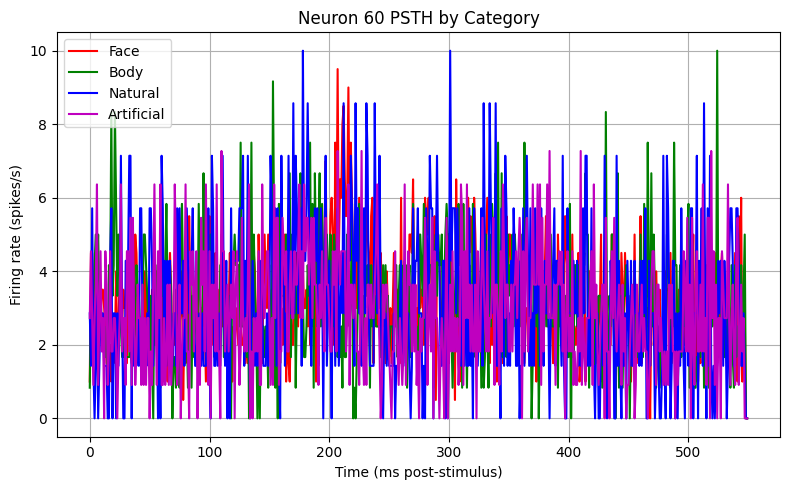

In [ ]:
max_pic = 500
StmLabels = np.zeros(max_pic + 1, dtype=int)

# Face:       1–200 → 0
# Body:     201–320 → 1
# Natural:  321–390 → 2
# Artificial 391–500 → 3
StmLabels[1:201]   = 0
StmLabels[201:321] = 1
StmLabels[321:391] = 2
StmLabels[391:501] = 3

trial_cats = StmLabels[pic_nums]

bin_width_s = 0.001
time_ms     = np.arange(550)

psth = {}
for cat in [0,1,2,3]:
    idx = np.where(trial_cats == cat)[0]
    sub = raster0[idx, :]
    psth[cat] = sub.sum(axis=0) / (len(idx) * bin_width_s)

# 4) PSTHs together
colors = ['r','g','b','m']
labels = ['Face','Body','Natural','Artificial']

plt.figure(figsize=(8,5))
for cat in [0,1,2,3]:
    plt.plot(time_ms, psth[cat], color=colors[cat], label=labels[cat])
plt.xlabel('Time (ms post-stimulus)')
plt.ylabel('Firing rate (spikes/s)')
plt.title('Neuron 60 PSTH by Category')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


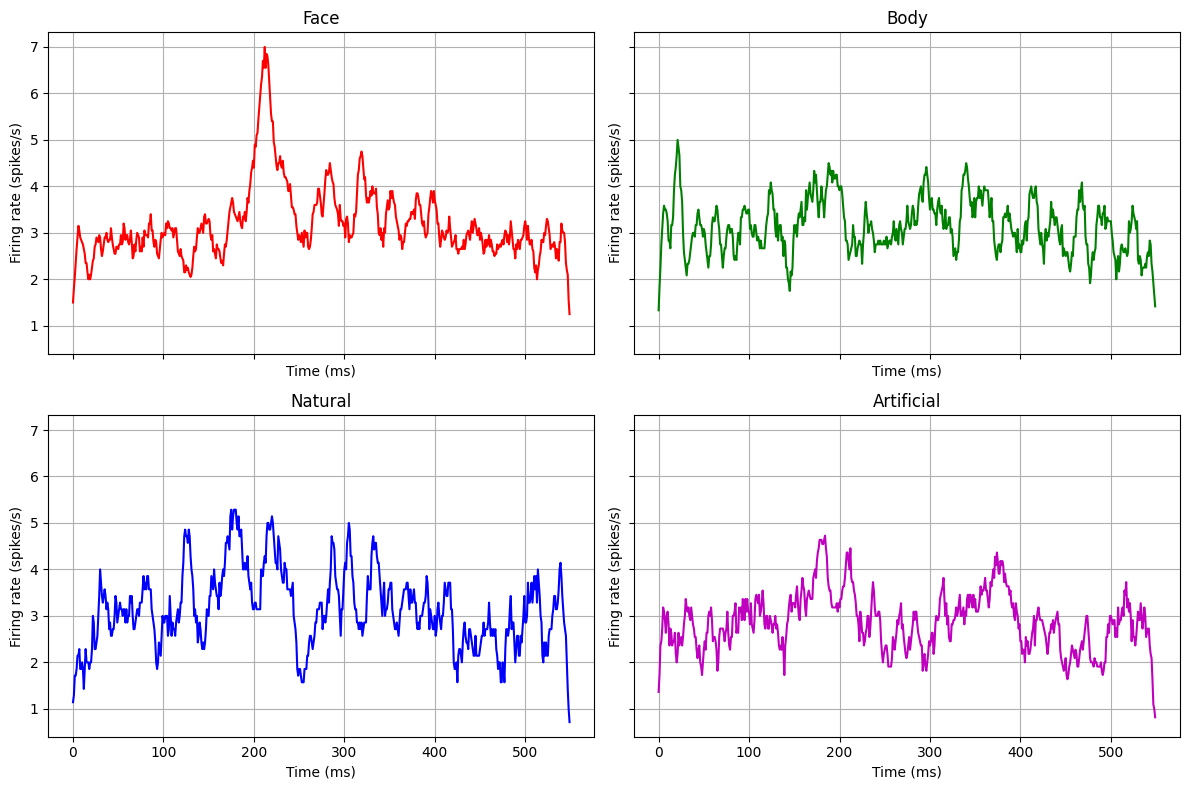

In [ ]:
time_ms = np.arange(550)
categories = ['Face', 'Body', 'Natural', 'Artificial']
colors = ['r', 'g', 'b', 'm']

window = 10
kernel = np.ones(window) / window
psth_smooth = {cat: np.convolve(psth[cat], kernel, mode='same') for cat in psth}

# 3) Each psth
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

for ax, cat in zip(axes.flatten(), psth_smooth):
    ax.plot(time_ms, psth_smooth[cat], color=colors[cat], linewidth=1.5)
    ax.set_title(categories[cat])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Firing rate (spikes/s)')
    ax.grid(True)

plt.tight_layout()
plt.show()


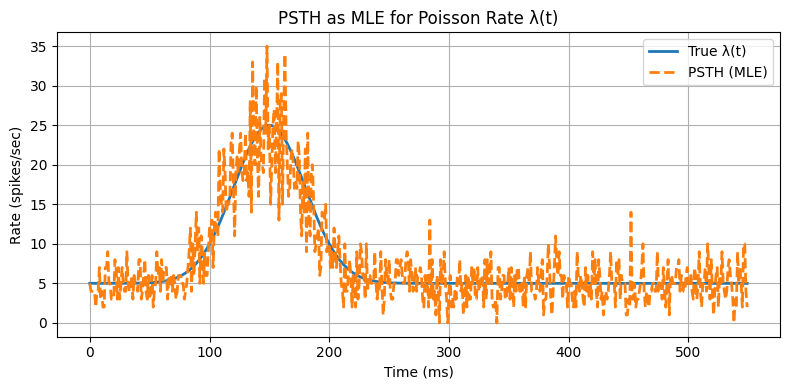

In [ ]:
n_trials = 1000
n_time   = 550
t = np.arange(n_time)
lambda_t = 5 + 20 * np.exp(-0.5 * ((t - 150) / 30)**2)

lambda_ms = lambda_t / 1000.0

spike_trains = np.random.poisson(lambda_ms[None, :], size=(n_trials, n_time))

psth = spike_trains.mean(axis=0) * 1000.0
lambda_mle = psth

# 4) true λ(t) vs. PSTH (MLE)
plt.figure(figsize=(8,4))
plt.plot(t, lambda_t,  label='True λ(t)', linewidth=2)
plt.plot(t, lambda_mle, '--', label='PSTH (MLE)', linewidth=2)
plt.xlabel('Time (ms)')
plt.ylabel('Rate (spikes/sec)')
plt.title('PSTH as MLE for Poisson Rate λ(t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Fano Factor

In [ ]:

def category_based_fano(raster_all, cm_all, StmLabels,
                        window_length=50, sliding_step=5):
    """
    Compute mean and variance of spike counts in sliding windows,
    separately for each category and each neuron.

    raster_all: list or array of shape (n_neurons,) where each element is (n_trials, n_time)
    cm_all:     list/array of shape (n_neurons,) where each element is (n_trials,) picture IDs
    StmLabels:  array mapping picture ID -> category (0–3)
    window_length: window size in bins (e.g. 200 for 100–300 ms)
    sliding_step:  step size in bins (e.g. 50 for 50 ms sliding)

    Returns:
      mean_vec: dict[cat] → array (n_neurons, n_time_slices)
      var_vec:  dict[cat] → array (n_neurons, n_time_slices)
      counts_dict: dict[cat] → list of per-neuron count arrays [(n_trials_cat, n_slices), …]
    """
    n_neurons = len(raster_all)
    n_time    = raster_all[0].shape[1]
    # number of sliding windows:
    n_slices = 1 + (n_time - window_length) // sliding_step

    mean_vec = {cat: np.zeros((n_neurons, n_slices)) for cat in range(4)}
    var_vec  = {cat: np.zeros((n_neurons, n_slices)) for cat in range(4)}
    counts_dict = {cat: [None]*n_neurons for cat in range(4)}

    for i in range(n_neurons):
        raster = raster_all[i]
        pics   = cm_all[i]
        cats   = StmLabels[pics]

        for cat in range(4):
            sel = np.where(cats == cat)[0]
            data = raster[sel]

            counts = np.zeros((data.shape[0], n_slices))

            for u in range(n_slices):
                start = sliding_step * u
                end   = start + window_length
                counts[:, u] = data[:, start:end].sum(axis=1)

            counts_dict[cat][i] = counts
            mean_vec[cat][i] = counts.mean(axis=0)
            var_vec [cat][i] = counts.var (axis=0)

    return mean_vec, var_vec, counts_dict


In [ ]:
mean_vec, var_vec, counts_dict = category_based_fano(raster_all, cm_all, StmLabels,
                                                     window_length=200, sliding_step=50)

mmff = {}
for cat in range(4):
    mean = mean_vec[cat]
    var  = var_vec[cat]
    ff   = np.divide(var, mean, out=np.full_like(var, np.nan), where=mean > 1e-2)
    mmff[cat] = ff


avg_ff = {cat: np.nanmean(mmff[cat], axis=0) for cat in range(4)}
n_slices = avg_ff[0].shape[0]
time = np.arange(n_slices) * 50 + 100

plt.figure(figsize=(10, 5))
colors = ['red', 'orange', 'green', 'blue']
labels = ['Face', 'Body', 'Natural', 'Artificial']

for cat in range(4):
    plt.plot(time, avg_ff[cat], label=labels[cat], color=colors[cat])

plt.xlabel("Time (ms)")
plt.ylabel("Mean-Matched Fano Factor")
plt.title("MMFF Across Time by Category")
plt.axhline(y=1.0, linestyle='--', color='gray', label='Poisson baseline')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


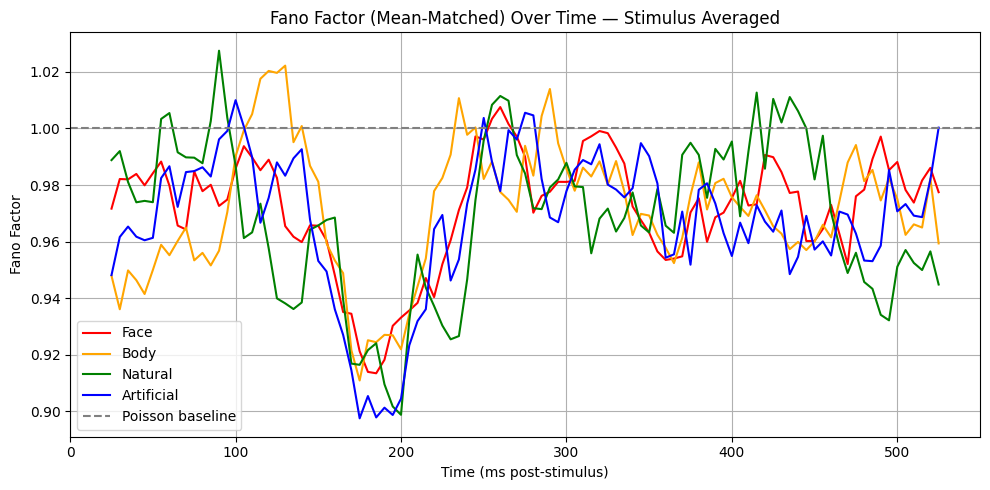

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
win_len = 50    # window length in ms/bins
step    = 5     # step size in ms/bins
n_neurons = len(raster_all)
n_time    = raster_all[0].shape[1]
n_slices  = 1 + (n_time - win_len) // step

# --- Step 1: Create stimulus-averaged raster: [n_neurons x n_stimuli x time] ---
trial_stim = cm_all[0]                      # shape: (5000,) — stimulus index per trial
stim_ids   = np.unique(trial_stim)          # should be 500 unique IDs
n_stim     = len(stim_ids)

raster_stim = np.zeros((n_neurons, n_stim, n_time), dtype=int)
for ni in range(n_neurons):
    for i, sid in enumerate(stim_ids):
        trials = np.where(trial_stim == sid)[0]
        raster_stim[ni, i, :] = raster_all[ni][trials, :].sum(axis=0)

# --- Step 2: Sliding window spike counts: [n_neurons x n_stimuli x n_slices] ---
counts = np.zeros((n_neurons, n_stim, n_slices), dtype=int)
for s in range(n_slices):
    start = s * step
    end   = start + win_len
    counts[:, :, s] = raster_stim[:, :, start:end].sum(axis=2)

# --- Step 3: Category labels per stimulus ---
StmLabels_full = np.zeros(n_stim, dtype=int)
StmLabels_full[(stim_ids >= 1)   & (stim_ids <= 200)] = 0  # Face
StmLabels_full[(stim_ids >= 201) & (stim_ids <= 320)] = 1  # Body
StmLabels_full[(stim_ids >= 321) & (stim_ids <= 390)] = 2  # Natural
StmLabels_full[(stim_ids >= 391) & (stim_ids <= 500)] = 3  # Artificial

# --- Step 4: Fano Factor computation ---
fano = np.zeros((4, n_slices))  # [category x time]
for c in range(4):
    idx = np.where(StmLabels_full == c)[0]
    for s in range(n_slices):
        data = counts[:, idx, s]  # [neurons x stimuli in category]
        var = np.var(data, axis=1)
        mean = np.mean(data, axis=1)
        ff = np.divide(var, mean, out=np.zeros_like(var, dtype=float), where=mean > 0)
        fano[c, s] = np.nanmean(ff)  # average over neurons

# --- Step 5: Plotting ---
times = np.arange(n_slices) * step + (win_len / 2)
labels = ['Face', 'Body', 'Natural', 'Artificial']
colors = ['red', 'orange', 'green', 'blue']

plt.figure(figsize=(10, 5))
for c in range(4):
    plt.plot(times, fano[c], label=labels[c], color=colors[c])
plt.axhline(1.0, linestyle='--', color='gray', label='Poisson baseline')
plt.xlabel('Time (ms post-stimulus)')
plt.ylabel('Fano Factor')
plt.title('Fano Factor (Mean-Matched) Over Time — Stimulus Averaged')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


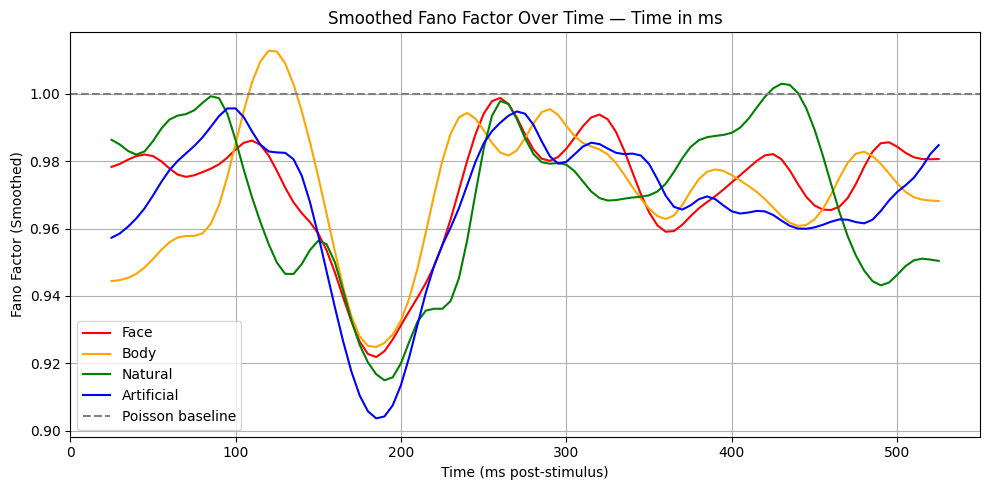

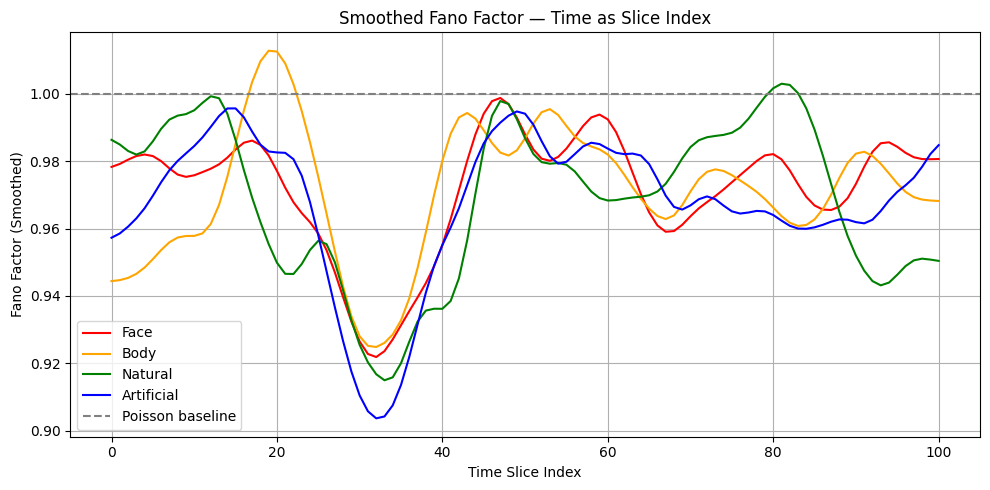

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

# --- Parameters ---
win_len = 50    # window length in ms/bins
step    = 5     # step size in ms/bins
n_neurons = len(raster_all)
n_time    = raster_all[0].shape[1]
n_slices  = 1 + (n_time - win_len) // step

# --- Step 1: Create stimulus-averaged raster: [n_neurons x n_stimuli x time] ---
trial_stim = cm_all[0]
stim_ids   = np.unique(trial_stim)
n_stim     = len(stim_ids)

raster_stim = np.zeros((n_neurons, n_stim, n_time), dtype=int)
for ni in range(n_neurons):
    for i, sid in enumerate(stim_ids):
        trials = np.where(trial_stim == sid)[0]
        raster_stim[ni, i, :] = raster_all[ni][trials, :].sum(axis=0)

# --- Step 2: Sliding window spike counts: [n_neurons x n_stimuli x n_slices] ---
counts = np.zeros((n_neurons, n_stim, n_slices), dtype=int)
for s in range(n_slices):
    start = s * step
    end   = start + win_len
    counts[:, :, s] = raster_stim[:, :, start:end].sum(axis=2)

# --- Step 3: Category labels per stimulus ---
StmLabels_full = np.zeros(n_stim, dtype=int)
StmLabels_full[(stim_ids >= 1)   & (stim_ids <= 200)] = 0  # Face
StmLabels_full[(stim_ids >= 201) & (stim_ids <= 320)] = 1  # Body
StmLabels_full[(stim_ids >= 321) & (stim_ids <= 390)] = 2  # Natural
StmLabels_full[(stim_ids >= 391) & (stim_ids <= 500)] = 3  # Artificial

# --- Step 4: Fano Factor computation ---
fano = np.zeros((4, n_slices))  # [category x time]
for c in range(4):
    idx = np.where(StmLabels_full == c)[0]
    for s in range(n_slices):
        data = counts[:, idx, s]  # [neurons x stimuli]
        var = np.var(data, axis=1)
        mean = np.mean(data, axis=1)
        ff = np.divide(var, mean, out=np.zeros_like(var, dtype=float), where=mean > 0)
        fano[c, s] = np.nanmean(ff)

# --- Step 5: Smooth the Fano curves ---
fano_smooth = scipy.ndimage.gaussian_filter1d(fano, sigma=2, axis=1)

# --- Step 6: Plotting ---
times = np.arange(n_slices) * step + win_len / 2
labels = ['Face', 'Body', 'Natural', 'Artificial']
colors = ['red', 'orange', 'green', 'blue']

# Plot 1: Time in ms
plt.figure(figsize=(10, 5))
for c in range(4):
    plt.plot(times, fano_smooth[c], label=labels[c], color=colors[c])
plt.axhline(1.0, linestyle='--', color='gray', label='Poisson baseline')
plt.xlabel('Time (ms post-stimulus)')
plt.ylabel('Fano Factor (Smoothed)')
plt.title('Smoothed Fano Factor Over Time — Time in ms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Slice index
plt.figure(figsize=(10, 5))
for c in range(4):
    plt.plot(np.arange(n_slices), fano_smooth[c], label=labels[c], color=colors[c])
plt.axhline(1.0, linestyle='--', color='gray', label='Poisson baseline')
plt.xlabel('Time Slice Index')
plt.ylabel('Fano Factor (Smoothed)')
plt.title('Smoothed Fano Factor — Time as Slice Index')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### SVM

In [ ]:
def multiclass_svm_psth(raster_all, cm_all, StmLabels, win_len=50, step=5, rate=0.7, n_rep=5):
    """
    Four-class SVM decoding on stimulus-averaged PSTH features.

    raster_all: list of (n_trials, n_time) arrays for each neuron
    cm_all:     list of (n_trials,) arrays of stimulus IDs (1–500) for each neuron
    StmLabels:  array mapping stimulus ID -> category (0–3)
    win_len:    window length in ms
    step:       step size in ms
    rate:       train/test split ratio per class
    n_rep:      number of repetitions for cross-validation
    """
    n_neurons = len(raster_all)
    n_time    = raster_all[0].shape[1]
    n_slices  = 1 + (n_time - win_len) // step

    # Build stimulus→trial mapping once
    trial_stim = cm_all[0]
    unique_stims = np.unique(trial_stim)
    stim_to_trials = {sid: np.where(trial_stim == sid)[0] for sid in unique_stims}

    stim_ids    = np.sort(unique_stims)
    stim_labels = StmLabels[stim_ids]

    accuracies = np.zeros(n_slices)

    for s in tqdm(range(n_slices), desc="Decoding windows"):
        start = s * step
        end   = start + win_len

        # Build feature matrix: (500 stimuli × 92 neurons)
        X = np.zeros((len(stim_ids), n_neurons), dtype=float)
        y = stim_labels.copy()

        for i, sid in enumerate(stim_ids):
            trials = stim_to_trials[sid]
            for ni in range(n_neurons):
                counts = raster_all[ni][trials, start:end].sum(axis=1)
                X[i, ni] = counts.sum()

        # Multiclass SVM decoding
        out, _ = gen_fx_get_svm(y, X, rate=rate, rep=n_rep)
        accuracies[s] = out['pt'].mean()

    # Plot
    times = np.arange(n_slices) * step + (win_len//2)
    plt.figure(figsize=(8,4))
    plt.plot(times, accuracies, label='4-class accuracy', linewidth=2)
    plt.axhline(0.25, linestyle='--', color='gray', label='Chance (25%)')
    plt.xlabel('Time (ms post-stimulus)')
    plt.ylabel('Accuracy')
    plt.title('Multiclass Decoding: 500 stimuli × 92 neurons')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return accuracies


Decoding windows: 100%|██████████| 101/101 [03:56<00:00,  2.34s/it]


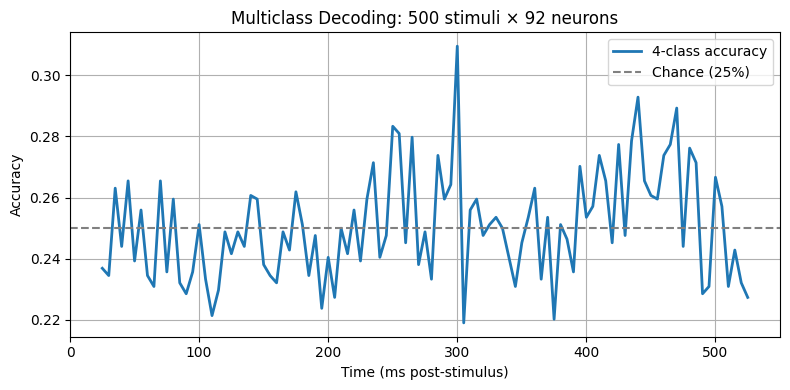

In [ ]:
accs = multiclass_svm_psth(raster_all, cm_all, StmLabels,
                           win_len=50, step=5, rate=0.7, n_rep=10)


In [ ]:
def gen_fx_get_equal_part(grp, rate):
    """
    Splits data into balanced training and testing sets for each class.

    Parameters:
        grp (np.ndarray): A vector of class labels for each sample (N,)
        rate (float): Proportion of samples per class to assign to training (e.g., 0.7)

    Returns:
        test (np.ndarray): Boolean array indicating test samples
        train (np.ndarray): Boolean array indicating train samples
    """
    grp = np.array(grp)
    catNo = np.unique(grp)
    asiz = []

    for cat in catNo:
        asiz.append(np.sum(grp == cat))

    minL = min(asiz)
    TrSiz = int(np.floor(rate * minL))
    TeSiz = minL - TrSiz

    train = np.zeros(grp.shape, dtype=bool)
    test = np.zeros(grp.shape, dtype=bool)

    for cat in catNo:
        ix = np.where(grp == cat)[0]
        np.random.shuffle(ix)
        train[ix[:TrSiz]] = True
        test[ix[-TeSiz:]] = True

    return test, train


In [ ]:

def gen_fx_get_svm(grp, I, rate, rep):
    """
    Trains and evaluates an SVM classifier over multiple repetitions.

    Parameters:
        grp (np.ndarray): Class labels (N,)
        I (np.ndarray): Feature matrix (N, D)
        rate (float): Proportion of training data per class
        rep (int): Number of repetitions

    Returns:
        out (dict): Contains accuracy, confusion matrices, per-class accuracy, and last model
        mdl: Last trained model
    """
    grp = np.array(grp)
    Pt = []  # Accuracy scores
    Tu = []  # Per-class accuracy
    Ct = []  # Confusion matrices

    for _ in range(rep):
        test, train = gen_fx_get_equal_part(grp, rate)

        cls, mdl = gen_fx_MC_SVM(I[test], I[train], grp[train])

        accuracy = np.sum(cls == grp[test]) / np.sum(test)
        Pt.append(accuracy)

        conf = confusion_matrix(grp[test], cls)
        Ct.append(conf)

        per_class_acc = np.diag(conf) / np.sum(conf, axis=1)
        Tu.append(per_class_acc)

    out = {
        "pt": np.array(Pt),
        "C": np.array(Ct),
        "tu": np.array(Tu),
        "model": mdl
    }

    return out, mdl


In [ ]:

def gen_fx_MC_SVM(sample, train, grp):
    """
    Multi-class SVM classification using one-vs-one strategy with voting.

    Parameters:
        sample (np.ndarray): Feature matrix of samples to classify (MxD)
        train (np.ndarray): Feature matrix of training samples (NxD)
        grp (np.ndarray): Class labels for the training samples (Nx1 or 1D)

    Returns:
        class_pred (np.ndarray): Predicted class labels for the input samples (Mx1)
        model (OneVsOneClassifier): Trained One-vs-One multi-class SVM model
    """
    grp = np.array(grp).flatten()
    classNo = np.unique(grp)
    cls_nu = len(classNo)

    # Store predictions from all pairwise classifiers
    vote_matrix = np.zeros((sample.shape[0], cls_nu * (cls_nu - 1) // 2))

    idx = 0
    for i in range(cls_nu):
        for j in range(i + 1, cls_nu):
            class_i = classNo[i]
            class_j = classNo[j]

            # Select samples from the two classes
            ix = np.where((grp == class_i) | (grp == class_j))[0]
            X_pair = train[ix]
            y_pair = grp[ix]

            # Train binary SVM
            clf = SVC(kernel='linear')
            clf.fit(X_pair, y_pair)

            # Predict test samples
            vote_matrix[:, idx] = clf.predict(sample)
            idx += 1

    # Majority voting
    class_pred, _ = mode(vote_matrix, axis=1)
    class_pred = class_pred.flatten()

    # Train ECOC-style model (sklearn uses OvO under the hood)
    model = OneVsOneClassifier(SVC(kernel='linear'))
    model.fit(train, grp)

    return class_pred, model


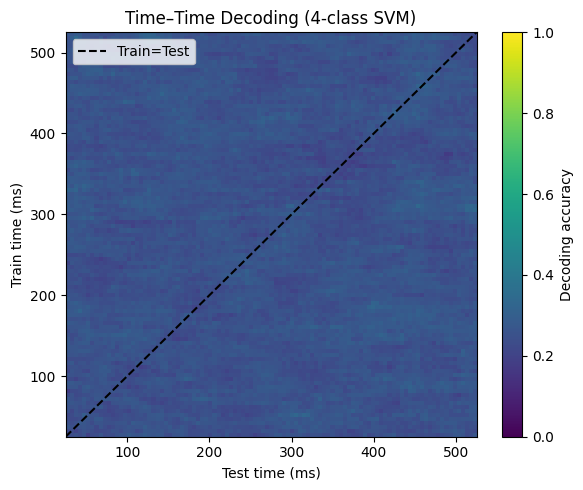

In [ ]:

# Parameters
win_len = 50
step    = 5
rate    = 0.7
n_rep   = 5
n_neurons = len(raster_all)
n_time    = raster_all[0].shape[1]
n_slices  = 1 + (n_time - win_len) // step

trial_stim = cm_all[0]
stim_ids   = np.sort(np.unique(trial_stim))
stim_to_trials = {sid: np.where(trial_stim == sid)[0] for sid in stim_ids}
n_stim = len(stim_ids)

Xstim = np.zeros((n_stim, n_neurons, n_slices), dtype=float)
for i, sid in enumerate(stim_ids):
    trials = stim_to_trials[sid]
    for s in range(n_slices):
        start = s * step
        end   = start + win_len
        # sum over repeats then over time within window
        for ni in range(n_neurons):
            counts = raster_all[ni][trials, start:end].sum(axis=1)
            Xstim[i, ni, s] = counts.sum()

grp = StmLabels[stim_ids]

dec_matrix = np.zeros((n_slices, n_slices))

for rep in range(n_rep):
    test_mask, train_mask = gen_fx_get_equal_part(grp, rate)

    for t_train in range(n_slices):
        X_train = Xstim[:, :, t_train]
        y_train = grp

        clf = OneVsOneClassifier(SVC(kernel='linear'))
        clf.fit(X_train[train_mask], y_train[train_mask])

        for t_test in range(n_slices):
            X_test = Xstim[:, :, t_test]
            y_pred = clf.predict(X_test[test_mask])
            acc = np.mean(y_pred == y_train[test_mask])
            dec_matrix[t_train, t_test] += acc

dec_matrix /= n_rep

times = np.arange(n_slices) * step + (win_len // 2)

plt.figure(figsize=(6,5))
plt.imshow(dec_matrix, origin='lower',
           extent=[times[0], times[-1], times[0], times[-1]],
           aspect='auto', vmin=0.2, vmax=0.4, cmap='viridis')
plt.colorbar(label='Decoding accuracy')
plt.plot([times[0], times[-1]], [times[0], times[-1]], 'k--', label='Train=Test')
plt.xlabel('Test time (ms)')
plt.ylabel('Train time (ms)')
plt.title('Time–Time Decoding (4‐class SVM)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


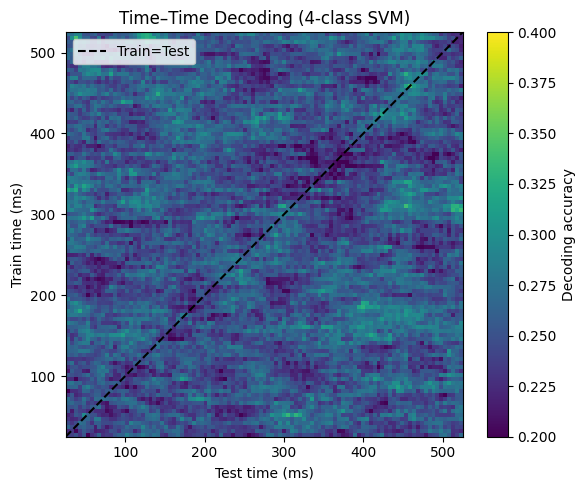

In [ ]:

plt.figure(figsize=(6,5))
plt.imshow(dec_matrix, origin='lower',
           extent=[times[0], times[-1], times[0], times[-1]],
           aspect='auto', vmin=0.2, vmax=0.4, cmap='viridis')
plt.colorbar(label='Decoding accuracy')
plt.plot([times[0], times[-1]], [times[0], times[-1]], 'k--', label='Train=Test')
plt.xlabel('Test time (ms)')
plt.ylabel('Train time (ms)')
plt.title('Time–Time Decoding (4‐class SVM)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

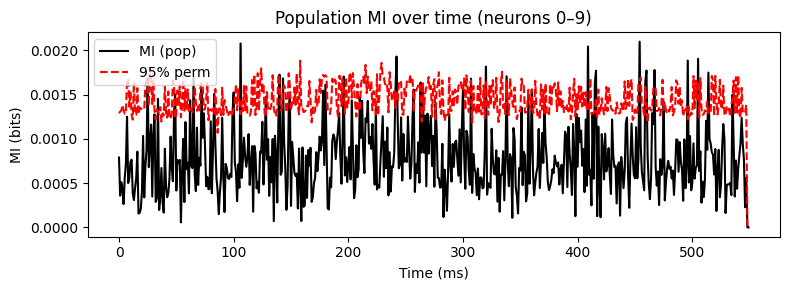

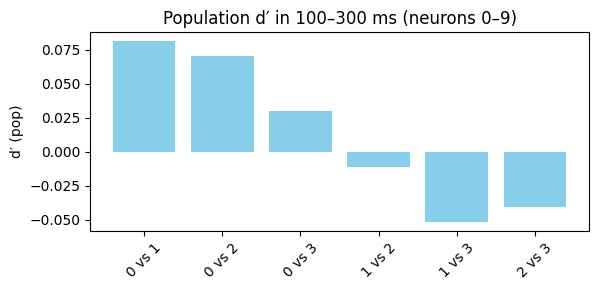

Population d-primes (neurons 0–9):
  Category 0 vs 1: d′ = 0.081
  Category 0 vs 2: d′ = 0.070
  Category 0 vs 3: d′ = 0.030
  Category 1 vs 2: d′ = -0.011
  Category 1 vs 3: d′ = -0.052
  Category 2 vs 3: d′ = -0.041


In [ ]:
from sklearn.metrics import mutual_info_score

# ---- Parameters ----
neuron_group = list(range(10))   # use neurons 0–9 as an example
n_time = raster_all[0].shape[1]
n_trials = raster_all[0].shape[0]

# Time window for d-prime
dp_start, dp_end = 100, 300      # ms-bins for d′
dp_slice = slice(dp_start, dp_end)

# 1) Build population spike count matrix: shape (n_trials, n_time)
#    by summing spike counts across the selected neurons at each time bin
pop_counts = np.zeros((n_trials, n_time), dtype=float)
for ni in neuron_group:
    pop_counts += raster_all[ni]

# 2) Mutual Information over time
labels = StmLabels[cm_all[0]]    # (n_trials,)

mi_ts = np.zeros(n_time)
null_thr = np.zeros(n_time)
n_perm = 500

for t in range(n_time):
    x = pop_counts[:, t]
    # discretize x into e.g. 20 bins
    bins = np.histogram_bin_edges(x, bins=20)
    x_bin = np.digitize(x, bins) - 1

    # compute observed MI
    mi_ts[t] = mutual_info_score(labels, x_bin)

    # permutation null
    mi_perm = np.zeros(n_perm)
    for k in range(n_perm):
        mi_perm[k] = mutual_info_score(np.random.permutation(labels), x_bin)
    null_thr[t] = np.percentile(mi_perm, 95)

# Plot MI
times = np.arange(n_time)
sig = mi_ts > null_thr

plt.figure(figsize=(8,3))
plt.plot(times, mi_ts, 'k', label='MI (pop)')
plt.plot(times, null_thr, 'r--', label='95% perm')
plt.fill_between(times, mi_ts, null_thr, where=sig, color='red', alpha=0.3)
plt.xlabel('Time (ms)')
plt.ylabel('MI (bits)')
plt.title('Population MI over time (neurons 0–9)')
plt.legend()
plt.tight_layout()
plt.show()

# 3) d-prime for each pair, using summed counts in [100:300] ms
pop_counts_window = pop_counts[:, dp_slice].sum(axis=1)  # (n_trials,)

# compute per-category vectors
cat_resps = {cat: pop_counts_window[labels==cat] for cat in range(4)}

from itertools import combinations

dprimes = {}
for (c1,c2) in combinations(range(4),2):
    x1 = cat_resps[c1]
    x2 = cat_resps[c2]
    mu1, mu2 = x1.mean(), x2.mean()
    s1, s2 = x1.std(), x2.std()
    d = (mu1 - mu2) / np.sqrt(0.5*(s1**2 + s2**2))
    dprimes[(c1,c2)] = d

# Bar plot of d-prime
pairs = list(dprimes.keys())
vals  = [dprimes[p] for p in pairs]
labels_pairs = [f"{p[0]} vs {p[1]}" for p in pairs]

plt.figure(figsize=(6,3))
plt.bar(range(len(vals)), vals, color='skyblue')
plt.xticks(range(len(vals)), labels_pairs, rotation=45)
plt.ylabel("d′ (pop)")
plt.title("Population d′ in 100–300 ms (neurons 0–9)")
plt.tight_layout()
plt.show()

# Print results
print("Population d-primes (neurons 0–9):")
for p,v in dprimes.items():
    print(f"  Category {p[0]} vs {p[1]}: d′ = {v:.3f}")


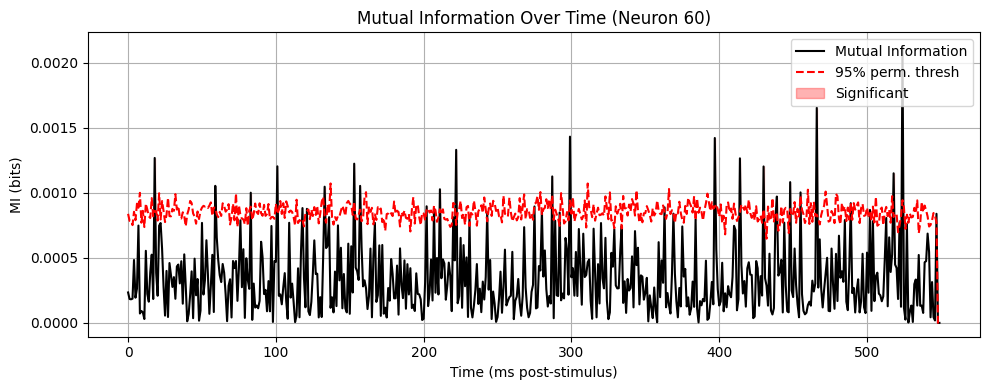

In [ ]:

trial_cats = StmLabels[pic_nums]

n_trials, n_time = raster0.shape

mi_time = np.zeros(n_time)
for t in range(n_time):
    counts_t = raster0[:, t]  # spike count per trial at time t (0 or 1)
    mi_time[t] = mutual_info_score(trial_cats, counts_t)

n_perm = 200
mi_perm = np.zeros((n_perm, n_time))

for i in range(n_perm):
    shuffled = np.random.permutation(trial_cats)
    for t in range(n_time):
        counts_t = raster0[:, t]
        mi_perm[i, t] = mutual_info_score(shuffled, counts_t)

mi_thresh = np.percentile(mi_perm, 95, axis=0)

time_ms = np.arange(n_time)  # 0…549 ms

plt.figure(figsize=(10,4))
plt.plot(time_ms, mi_time, label='Mutual Information', color='k')
plt.plot(time_ms, mi_thresh, '--', label='95% perm. thresh', color='r')
plt.fill_between(time_ms, mi_time, mi_thresh, where=(mi_time>mi_thresh),
                 color='r', alpha=0.3, label='Significant')

plt.xlabel('Time (ms post‐stimulus)')
plt.ylabel('MI (bits)')
plt.title('Mutual Information Over Time (Neuron 60)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


d′(Face vs Body) = 0.056
d′(Face vs Natural) = 0.014
d′(Face vs Artificial) = 0.092
d′(Body vs Natural) = -0.042
d′(Body vs Artificial) = 0.036
d′(Natural vs Artificial) = 0.078


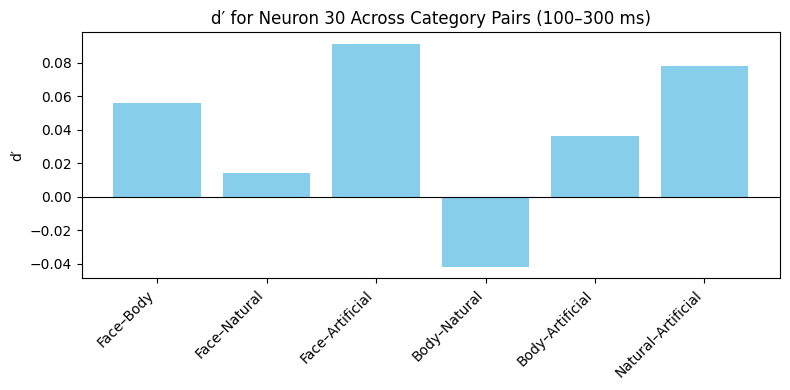

In [ ]:
start_ms, end_ms = 100, 300
counts = raster0[:, start_ms:end_ms].sum(axis=1)
trial_cats = StmLabels[pic_nums]

pairs = list(combinations(range(4), 2))
dprimes = []
labels = ['Face','Body','Natural','Artificial']

for (c1, c2) in pairs:
    x1 = counts[trial_cats == c1]
    x2 = counts[trial_cats == c2]
    mu1, mu2 = x1.mean(), x2.mean()
    s1, s2   = x1.std(ddof=1), x2.std(ddof=1)
    s_pooled = np.sqrt(0.5*(s1**2 + s2**2))
    # d-prime
    dp = (mu1 - mu2) / s_pooled if s_pooled>0 else np.nan
    dprimes.append(dp)
    print(f"d′({labels[c1]} vs {labels[c2]}) = {dp:.3f}")

x = np.arange(len(pairs))
pair_labels = [f"{labels[c1]}–{labels[c2]}" for c1,c2 in pairs]

plt.figure(figsize=(8,4))
plt.bar(x, dprimes, color='skyblue')
plt.xticks(x, pair_labels, rotation=45, ha='right')
plt.ylabel("d′")
plt.title("d′ for Neuron 30 Across Category Pairs (100–300 ms)")
plt.axhline(0, color='k', linewidth=0.8)
plt.tight_layout()
plt.show()


## Population analysis

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


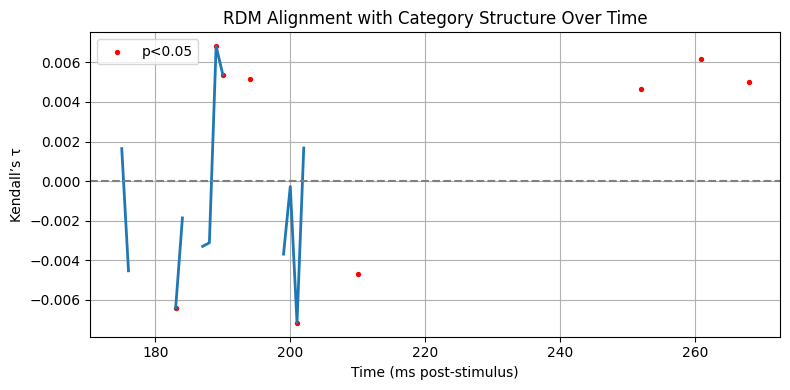

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy.io import savemat

# --- Assume you already have: ---
# raster_stim: [n_neurons x n_stimuli x n_time]
# stim_ids:    (n_stimuli,) array of stimulus IDs (1–500)
# StmLabels_full: (n_stimuli,) array mapping each stimulus ID to category 0–3

# If not, build raster_stim as in previous code.

n_neurons, n_stimuli, n_time = raster_stim.shape

# --- 1) Compute neural RDMs over time (1 − Pearson’s r) ---
RDM_neural = np.zeros((n_stimuli, n_stimuli, n_time))
for t in range(n_time):
    X = raster_stim[:, :, t]  # [n_neurons x n_stimuli]
    # Normalize each column to zero mean / unit var to stabilize correlation
    X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-12)
    # Compute correlation matrix and convert to dissimilarity
    corr = np.corrcoef(X.T)            # [n_stimuli x n_stimuli]
    RDM_neural[:, :, t] = 1.0 - corr

# --- 2) Build ground‐truth RDM: same category = 0, different = 1 ---
RDM_truth = np.zeros((n_stimuli, n_stimuli))
for i in range(n_stimuli):
    for j in range(n_stimuli):
        RDM_truth[i, j] = 0 if StmLabels_full[i] == StmLabels_full[j] else 1

# --- 3) Vectorize upper‐triangles for correlation ---
triu_idx = np.triu_indices(n_stimuli, k=1)
truth_vec = RDM_truth[triu_idx]

# --- 4) Compute Kendall’s tau over time ---
tau_time = np.zeros(n_time)
pval_time = np.zeros(n_time)
for t in range(n_time):
    neu_vec = RDM_neural[:, :, t][triu_idx]
    tau, p = kendalltau(truth_vec, neu_vec)
    tau_time[t], pval_time[t] = tau, p

# --- 5) Plot tau(t) ---
times = np.arange(n_time)  # if each t is 1 ms; adjust if needed
plt.figure(figsize=(8,4))
plt.plot(times, tau_time, linewidth=2)
plt.axhline(0, color='gray', linestyle='--')
# Mark significant time points (p<0.05)
sig = pval_time < 0.05
plt.scatter(times[sig], tau_time[sig], color='red', s=8, label='p<0.05')
plt.xlabel('Time (ms post-stimulus)')
plt.ylabel("Kendall’s τ")
plt.title('RDM Alignment with Category Structure Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 6) Save results ---
savemat('RDM_neural.mat', {'RDM_neural': RDM_neural})
savemat('RDM_truth.mat',  {'RDM_truth': RDM_truth})
savemat('tau_time.mat',    {'tau_time': tau_time, 'pval_time': pval_time})


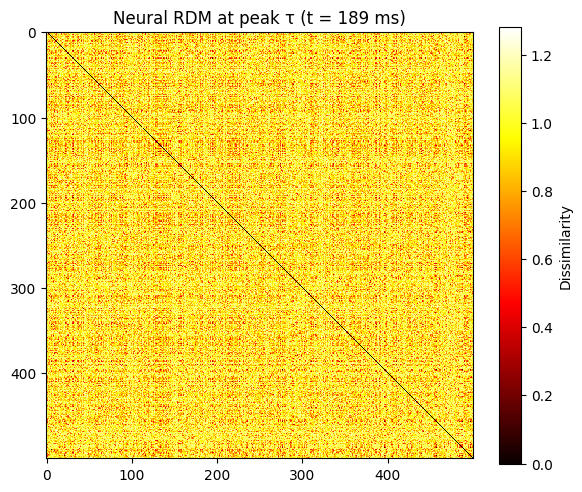

In [ ]:
peak_t = np.nanargmax(tau_time)
sort_idx = np.argsort(StmLabels_full)

plt.figure(figsize=(6, 5))
plt.imshow(RDM_neural[sort_idx][:, sort_idx, peak_t], cmap='hot', interpolation='nearest')
plt.title(f"Neural RDM at peak τ (t = {peak_t} ms)")
plt.colorbar(label='Dissimilarity')
plt.tight_layout()
plt.show()


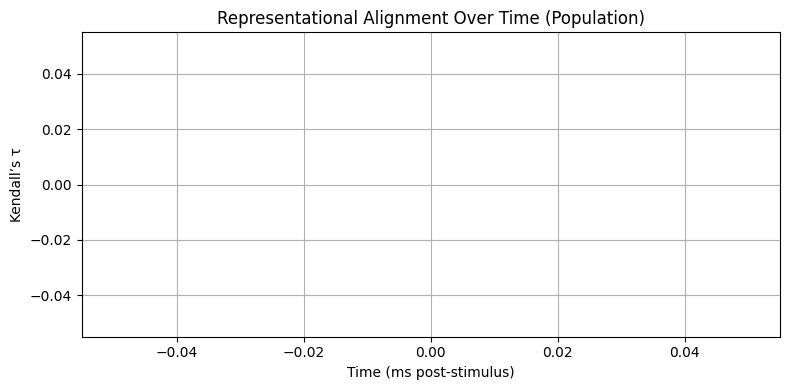

In [ ]:

# --- 1. Assume you already have these from earlier steps ---
# raster_all: list of 92 arrays, each shape (5000 trials, 550 timebins)
# cm_all:     list of 92 arrays, each shape (5000,), picture IDs per trial

# Build trial_cats from cm_all[0]:
pic_nums = cm_all[0]  # use the same trial order for all neurons

# Map picture IDs → category codes
StmLabels = np.zeros(pic_nums.max()+1, int)
StmLabels[1:201]   = 0  # Face
StmLabels[201:321] = 1  # Body
StmLabels[321:391] = 2  # Natural
StmLabels[391:501] = 3  # Artificial

trial_cats = StmLabels[pic_nums]  # shape (5000,)

# --- 2. Stack population data: (trials, neurons, time) ---
data = np.stack(raster_all, axis=1)  # shape (5000, 92, 550)

# --- 3. Ground-truth RDM (4×4) and vectorize ---
gt_rdm = np.ones((4,4)) - np.eye(4)
gt_vec = squareform(gt_rdm, checks=False)

# --- 4. Compute time‐resolved Kendall’s τ ---
n_time = data.shape[2]
tau_time = np.zeros(n_time)

for t in range(n_time):
    # Category‐mean population vector at time t: shape (4 categories, 92 neurons)
    cat_means = np.zeros((4, data.shape[1]))
    for cat in range(4):
        idx = np.where(trial_cats == cat)[0]
        cat_means[cat] = data[idx, :, t].mean(axis=0)
    # Neural RDM = 1 – Pearson correlation between those category means
    corr       = np.corrcoef(cat_means)
    neural_rdm = 1 - corr
    neural_vec = squareform(neural_rdm, checks=False)
    tau_time[t], _ = kendalltau(gt_vec, neural_vec)

# --- 5. Plot the alignment curve ---
time_ms = np.arange(n_time)  # 0…549 ms
plt.figure(figsize=(8,4))
plt.plot(time_ms, tau_time, color='k', linewidth=1.5)
plt.xlabel('Time (ms post‐stimulus)')
plt.ylabel("Kendall’s τ")
plt.title('Representational Alignment Over Time (Population)')
plt.grid(True)
plt.tight_layout()
plt.show()


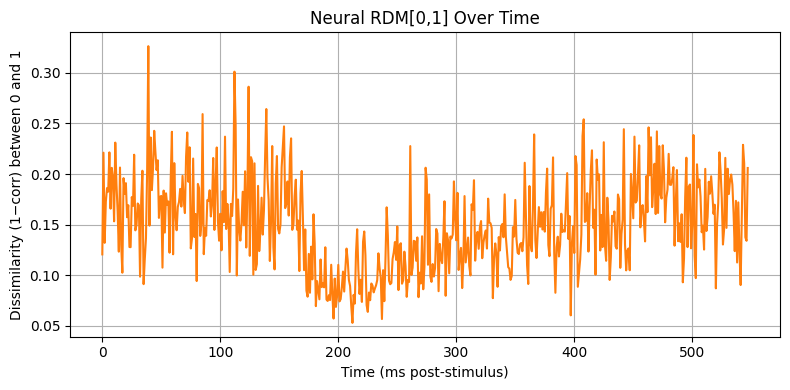

In [ ]:

# ─ assuming you already have: ─
#   data           # shape (n_trials=5000, n_neurons=92, n_time=550)
#   trial_cats     # shape (5000,), values in {0,1,2,3} for the four categories

# 1) Precompute neural RDMs for each time slice
n_time = data.shape[2]
neural_rdms = np.zeros((n_time, 4, 4))

for t in range(n_time):
    # compute category‐mean population pattern at time t
    cat_means = np.zeros((4, data.shape[1]))
    for cat in range(4):
        idx = np.where(trial_cats == cat)[0]
        cat_means[cat] = data[idx, :, t].mean(axis=0)
    # build 4×4 RDM = 1 − corr
    corr = np.corrcoef(cat_means)
    neural_rdms[t] = 1 - corr

# 2) Now pick any pair of categories (e.g. Face(0) vs Body(1)) to inspect their dissimilarity over time
c1, c2 = 0, 1  # change to any pair in {0,1,2,3}
dissim_ts = neural_rdms[:, c1, c2]  # length = 550

# 3) Plot it
time_ms = np.arange(n_time)
plt.figure(figsize=(8,4))
plt.plot(time_ms, dissim_ts, color='C1', lw=1.5)
plt.xlabel('Time (ms post‐stimulus)')
plt.ylabel(f'Dissimilarity (1−corr) between {c1} and {c2}')
plt.title(f'Neural RDM[{c1},{c2}] Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

# raster_all: list of length 92
data = np.stack(raster_all, axis=1)
# Now data.shape == (5000 trials, 92 neurons, 550 time bins)

pic_nums = cm_all[0]  # (5000,)


In [ ]:
StmLabels = np.zeros(pic_nums.max()+1, dtype=int)
StmLabels[1:201]   = 0  # Face
StmLabels[201:321] = 1  # Body
StmLabels[321:391] = 2  # Natural
StmLabels[391:501] = 3  # Artificial

trial_cats = StmLabels[pic_nums]  # (5000,)


In [ ]:

gt_rdm = np.ones((4,4)) - np.eye(4)  # 0 on diag, 1 else
gt_vec = squareform(gt_rdm, checks=False)


In [ ]:

n_time   = data.shape[2]  # 550
tau_time = np.zeros(n_time)

for t in range(n_time):
    # 4A) Compute the mean response of each category (4×92)
    cat_means = np.zeros((4, data.shape[1]))
    for cat in range(4):
        idx = np.where(trial_cats == cat)[0]
        cat_means[cat] = data[idx, :, t].mean(axis=0)
    # 4B) Neural RDM = 1 − Pearson corr between these 4 vectors
    corr       = np.corrcoef(cat_means)
    neural_rdm = 1 - corr
    neural_vec = squareform(neural_rdm, checks=False)
    # 4C) Kendall’s τ with ground truth
    tau_time[t], _ = kendalltau(gt_vec, neural_vec)


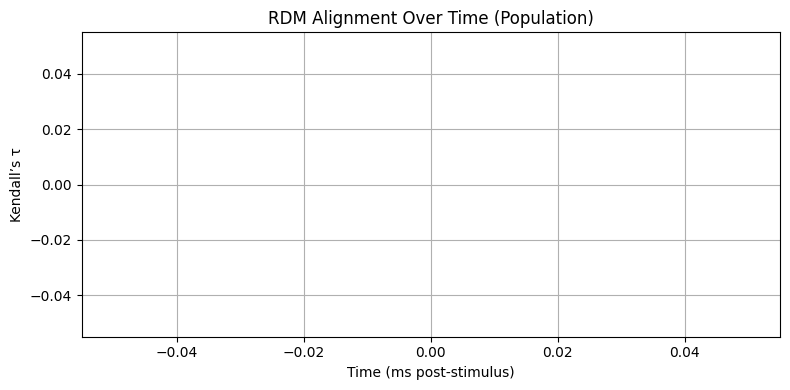

In [ ]:

time_ms = np.arange(n_time)  # 0…549

plt.figure(figsize=(8,4))
plt.plot(time_ms, tau_time, color='k', lw=1.5)
plt.xlabel('Time (ms post-stimulus)')
plt.ylabel("Kendall’s τ")
plt.title('RDM Alignment Over Time (Population)')
plt.grid(True)
plt.tight_layout()
plt.show()


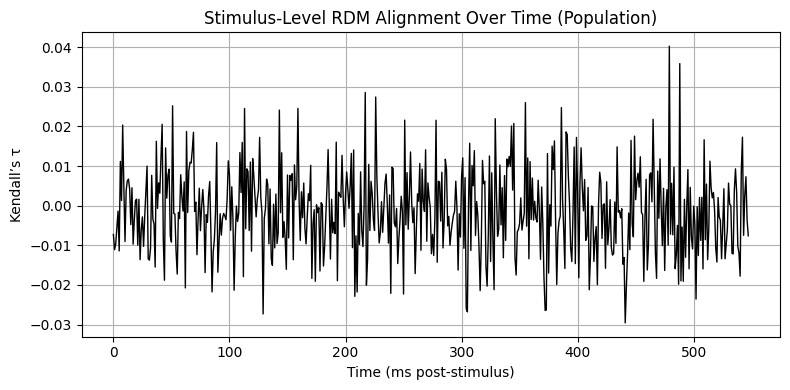

In [ ]:

# 1) You already have:
#    raster_all : list of 92 arrays, each (5000 trials × 550 timebins)
#    cm_all     : list of 92 arrays, each (5000,) picture IDs per trial
#    StmLabels  : array mapping picture ID → category (0–3)

# Use cm_all[0] as the canonical trial→picture mapping
pic_nums = cm_all[0]             # shape (5000,)
n_trials, n_time = raster_all[0].shape
n_stim = pic_nums.max()          # e.g. 500 unique pictures
n_neurons = len(raster_all)

# 2) Stack into a population tensor: (trials, neurons, time)
data = np.stack(raster_all, axis=1)  # shape (5000, 92, 550)

# 3) Build ground‐truth RDM (n_stim×n_stim):
#    0 if same category, 1 if different
stim_cats = StmLabels[np.arange(1, n_stim+1)]
gt_rdm = np.zeros((n_stim, n_stim), dtype=int)
for i in range(n_stim):
    for j in range(n_stim):
        gt_rdm[i,j] = int(stim_cats[i] != stim_cats[j])
gt_vec = squareform(gt_rdm, checks=False)

# 4) Preallocate τ‐vs‐time
tau_time = np.zeros(n_time)

# 5) For each timebin, build the neural RDM and compute τ
for t in range(n_time):
    # 5A) Compute each stimulus’s mean pattern (over all trials of that picture)
    stim_means = np.zeros((n_stim, n_neurons))
    for s in range(1, n_stim+1):
        idx = np.where(pic_nums == s)[0]
        stim_means[s-1] = data[idx, :, t].mean(axis=0)
    # 5B) Neural RDM via Euclidean distance
    neural_rdm = squareform(pdist(stim_means, metric='euclidean'))
    neural_vec = squareform(neural_rdm, checks=False)
    # 5C) Kendall’s τ with ground truth
    tau_time[t], _ = kendalltau(gt_vec, neural_vec)

# 6) Plot τ over time
time_ms = np.arange(n_time)  # 0…549
plt.figure(figsize=(8,4))
plt.plot(time_ms, tau_time, color='k', linewidth=1)
plt.xlabel('Time (ms post‐stimulus)')
plt.ylabel("Kendall’s τ")
plt.title('Stimulus‐Level RDM Alignment Over Time (Population)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

# Suppose tau_time is your array of length 550 with some nan entries
# 1) Find indices that are not nan
valid = ~np.isnan(tau_time)

# 2) If you want to inspect the first few invalid times:
invalid_times = np.where(~valid)[0]
print("Time bins with undefined τ (nan):", invalid_times[:10], "...")

# 3) Use nanargmax to ignore nan
peak_t = np.nanargmax(tau_time)
peak_val = tau_time[peak_t]
print(f"Peak Kendall’s τ of {peak_val:.3f} occurs at {peak_t} ms post‐stimulus")


Time bins with undefined τ (nan): [548 549] ...
Peak Kendall’s τ of 0.040 occurs at 479 ms post‐stimulus


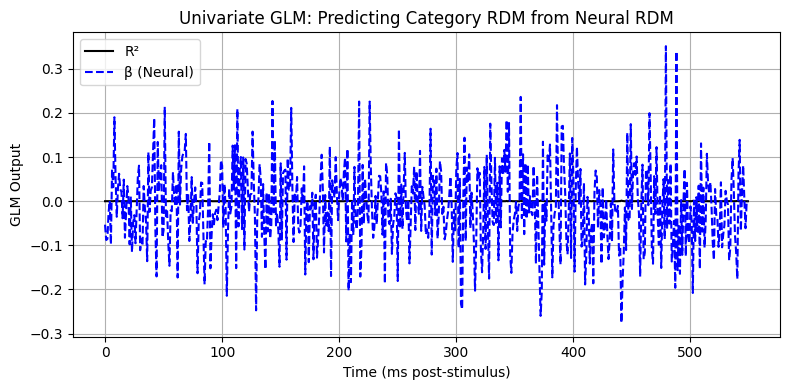

In [ ]:

# Assume:
# - data: shape (5000, 92, 550)  (trials × neurons × time)
# - pic_nums: (5000,) picture IDs in [1, 500]
# - StmLabels: shape (501,) with picture category labels (0–3)

n_stim = 500
n_time = data.shape[2]

# Ground-truth RDM (same/diff category)
gt_rdm = np.zeros((n_stim, n_stim), int)
stim_cats = StmLabels[1:501]
for i in range(n_stim):
    for j in range(n_stim):
        gt_rdm[i,j] = int(stim_cats[i] != stim_cats[j])
gt_vec = squareform(gt_rdm, checks=False)

# Build neural RDMs across time
neural_mat = np.zeros((n_time, len(gt_vec)))
for t in range(n_time):
    stim_means = np.zeros((n_stim, data.shape[1]))
    for s in range(1, n_stim+1):
        idx = np.where(pic_nums == s)[0]
        stim_means[s-1] = data[idx, :, t].mean(axis=0)
    neural_rdm = squareform(pdist(stim_means, metric='euclidean'))
    neural_mat[t] = squareform(neural_rdm, checks=False)

# Fit univariate regression: GT_RDM ~ Neural_RDM
rsquared = np.zeros(n_time)
beta     = np.zeros(n_time)
for t in range(n_time):
    X = sm.add_constant(neural_mat[t])  # Add intercept
    model = sm.OLS(gt_vec, X).fit()
    beta[t] = model.params[1]
    rsquared[t] = model.rsquared

# Plot
time = np.arange(n_time)
plt.figure(figsize=(8, 4))
plt.plot(time, rsquared, label='R²', color='black')
plt.plot(time, beta, label='β (Neural)', linestyle='--', color='blue')
plt.xlabel('Time (ms post-stimulus)')
plt.ylabel('GLM Output')
plt.title('Univariate GLM: Predicting Category RDM from Neural RDM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
peak_t = np.argmax(rsquared)
print(f"Max R² of {rsquared[peak_t]:.3f} at {peak_t} ms")


Max R² of 0.002 at 479 ms


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.6/423.6 kB 9.1 MB/s eta 0:00:00


In [ ]:
# Suppose lfp_trials is (5000 trials, 550 timepoints, sampled at 1 kHz)
lfp_trials = raster_all[0]  # replace with your actual LFP matrix, not the spike raster!
trial_cats = StmLabels[pic_nums]


/usr/local/lib/python3.11/dist-packages/tensorpac/methods/meth_surrogates.py:159: RuntimeWarning: invalid value encountered in divide
  pac /= s_std


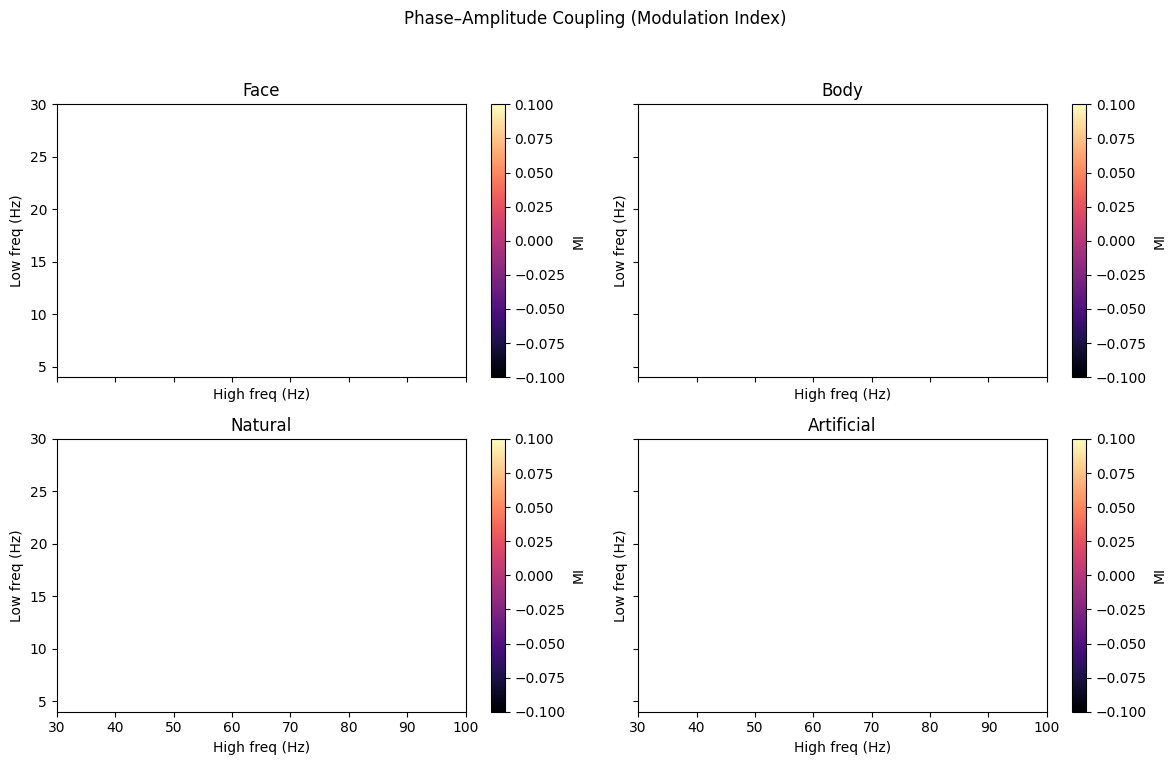

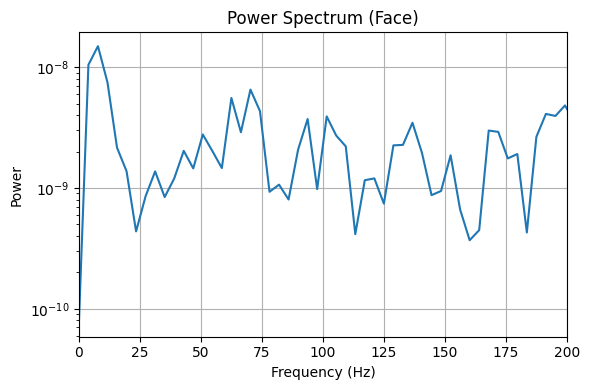

In [ ]:

# Example LFP: replace with your real LFP data (n_trials × n_times)
# Here I'm just re‐using raster_all[0] as a placeholder; use your actual LFP.
lfp_trials = raster_all[0]  # shape (n_trials=5000, n_times=550)
trial_cats = StmLabels[pic_nums]

# 1) Define frequency bands
fL = np.arange(4, 31, 2)    # low freq 4–30 Hz
fH = np.arange(30, 101, 5)  # high freq 30–100 Hz

# 2) Initialize Pac object for Modulation Index (Tort’s method = idpac=1)

# Use Tort's method (1), no normalization (0), no surrogates (0)
p = Pac(idpac=(1, 2, 4), f_pha=fL, f_amp=fH, dcomplex='hilbert', verbose=False)

# 3) Compute and plot PAC comodulograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
for cat, ax in zip(range(4), axs.flatten()):
    idx = np.where(trial_cats == cat)[0]
    data_cat = lfp_trials[idx]  # (n_trials_cat, n_times)
    # filterfit returns shape (len(fL), len(fH), n_epochs)
    pac = p.filterfit(1000, data_cat)
    # average across epochs (trials)
    mi = pac.mean(axis=2)
    im = ax.imshow(mi, origin='lower',
                   extent=[fH[0], fH[-1], fL[0], fL[-1]],
                   aspect='auto', cmap='magma')
    ax.set_title(['Face','Body','Natural','Artificial'][cat])
    ax.set_xlabel('High freq (Hz)')
    ax.set_ylabel('Low freq (Hz)')
    fig.colorbar(im, ax=ax, label='MI')

plt.suptitle('Phase–Amplitude Coupling (Modulation Index)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 4) Plot power spectrum for one category
cat = 0  # Face
idx = np.where(trial_cats == cat)[0]
lfp_mean = lfp_trials[idx].mean(axis=0)

f, Pxx = welch(lfp_mean, fs=1000, nperseg=256)
plt.figure(figsize=(6,4))
plt.semilogy(f, Pxx)
plt.xlim(0,200)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power Spectrum (Face)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorpac import Pac

# ----------------------
# Assumed variables:
# lfp_trials: np.array of shape (n_trials, n_times)
# trial_labels: np.array of shape (n_trials,) with values 0–3 for categories
# ----------------------

sf = 1000  # Sampling frequency in Hz
f_pha = (4, 8)      # Phase frequency range (e.g., theta)
f_amp = (30, 150)   # Amplitude frequency range (e.g., gamma)

n_bins = 18         # Number of phase bins

# Create TensorPAC object (using Tort's method with surrogate correction)
p = Pac(idpac=(1, 2, 4), f_pha=f_pha, f_amp=f_amp, dcomplex='hilbert', verbose='ERROR')

# Loop through categories (0=Face, 1=Body, 2=Natural, 3=Artificial)
for cat in np.unique(trial_labels):
    data_cat = lfp_trials[trial_labels == cat]

    # Compute PAC (returns shape: [n_phase_freqs, n_amp_freqs, n_trials])
    pac = p.filterfit(sf=sf, x=data_cat)

    # Average over trials
    mi = pac.mean(axis=2)

    # Plot comodulogram
    plt.figure(figsize=(6, 5))
    p.comodulogram(mi, title=f'PAC (Category {cat})', cmap='viridis')
    plt.tight_layout()
    plt.show()


NameError: name 'trial_labels' is not defined

In [ ]:
print(data_cat.shape)  # Should be (n_trials, n_times)


(1100, 550)


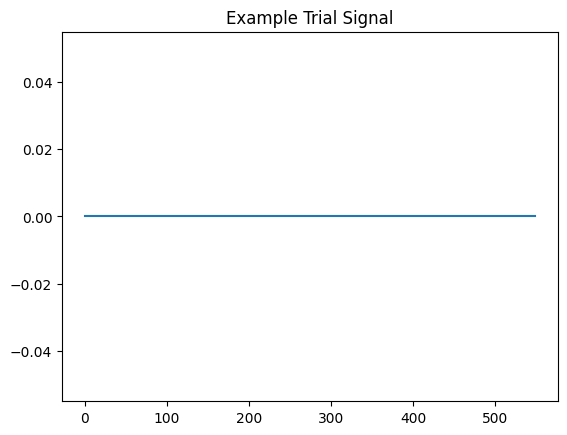

In [ ]:
plt.plot(data_cat[0])
plt.title("Example Trial Signal")
plt.show()


In [ ]:
f_pha = np.linspace(4, 12, 10)   # theta
f_amp = np.linspace(30, 100, 10) # gamma


In [ ]:
p = Pac(idpac=(1, 2, 4), f_pha=f_pha, f_amp=f_amp)


In [ ]:
pac = p.filterfit(1000, data_cat)
mi = pac.mean(axis=2)  # Mean over trials


In [ ]:
print(mi.shape)  # Should be (len(f_pha), len(f_amp))


(9, 9)


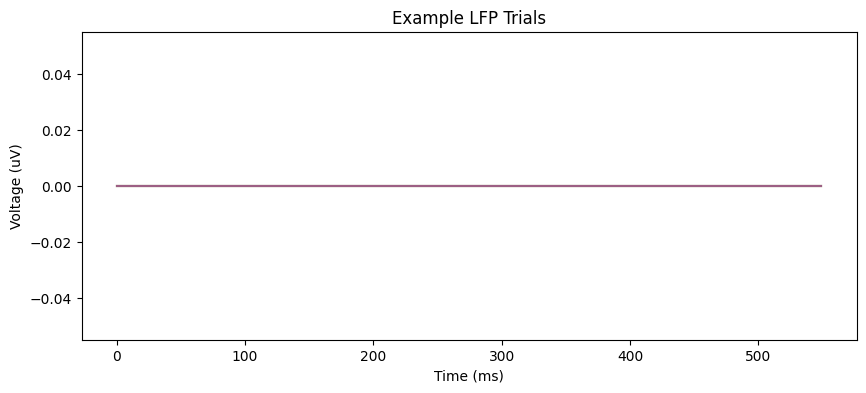

In [ ]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.plot(lfp_trials[i], alpha=0.6)
plt.title("Example LFP Trials")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (uV)")
plt.show()


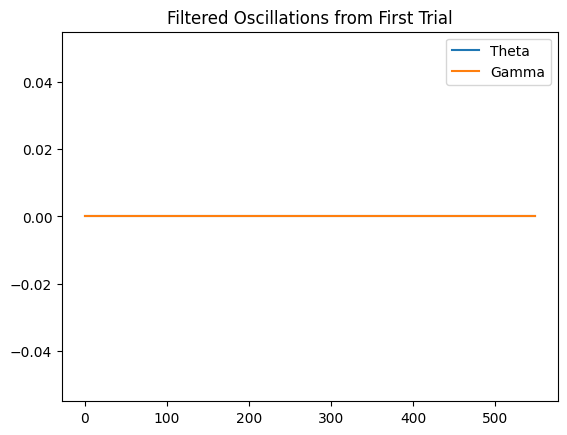

In [ ]:

def bandpass_filter(data, low, high, fs=1000, order=3):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, data)

# Try theta and gamma bands
theta = bandpass_filter(lfp_trials[0], 4, 8)
gamma = bandpass_filter(lfp_trials[0], 30, 80)

plt.plot(theta, label='Theta')
plt.plot(gamma, label='Gamma')
plt.legend()
plt.title("Filtered Oscillations from First Trial")
plt.show()


In [ ]:
for i in range(5):
    data_cat = lfp_trials[grp == i]
    print(f"Category {i} mean signal:", data_cat.mean())
    print(f"Category {i} std dev:", data_cat.std())


Category 0 mean signal: 0.002060909090909091
Category 0 std dev: 0.04535043268402297
Category 1 mean signal: 0.0018378787878787879
Category 1 std dev: 0.0428310750441762
Category 2 mean signal: 0.002007792207792208
Category 2 std dev: 0.044763388815443096
Category 3 mean signal: 0.001778512396694215
Category 3 std dev: 0.04213489397576574
Category 4 mean signal: nan
Category 4 std dev: nan


<ipython-input-83-9d5a9b714f94>:3: RuntimeWarning: Mean of empty slice.
  print(f"Category {i} mean signal:", data_cat.mean())
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
for ni in range(92):
    lfp = raster_all[ni].astype(float)
    pic_nums = cm_all[ni]
    mask = pic_nums < 501  # Filter valid image trials
    lfp = lfp[mask]

    mean_signal = np.mean(lfp)
    std_signal  = np.std(lfp)
    print(f"Neuron {ni:02d} — Mean: {mean_signal:.4f}, Std: {std_signal:.4f}")


NameError: name 'raster_all' is not defined